# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



In [1]:
# Load dependencies
import os
import copy
import h5py
import cPickle as pickle
from glob import glob
from random import shuffle

import cv2
from PIL import Image
from IPython.display import SVG

import numpy as np
import pandas as pd

import sklearn.utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import keras
import keras.backend as K

from keras.models import Model
from keras.layers import Input, BatchNormalization, Convolution2D, Dense, Dropout, MaxPooling2D, Flatten
from keras.layers import AveragePooling2D, GlobalAveragePooling2D, concatenate, UpSampling2D, Conv2DTranspose

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


#### Load the MNIST dataset

In [14]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

#### Generate synthetic data based on MNIST

In [15]:
def create_numbers(numbers, number_labels, maxlength=5, digit_sz=(28, 28), return_label=False):
    # Attention: Only coded to work with grayscale images at the moment.

    # Randomly choose a number length:
    img_len = np.random.choice(range(maxlength)) + 1
    label = np.empty(5, dtype='str')

    #print "length: ", img_len


    # Randomly choose where in our image the sequence of numbers will appear
    if img_len < maxlength:
        st_point = np.random.choice(maxlength - img_len)
    else:
        st_point = 0
    
    #print "start:", st_point

    charmap = np.zeros(maxlength)
    charmap[st_point:st_point + img_len] = 1
    
    #print "charmap: ", charmap

    # Define a blank character - this will ensure our input image always have the same dimensions
    blank_char = np.zeros_like(digit_sz)
    blank_lbl = "."

    # Initialize a blank image with maxlen * digit_dz width and digit_sz height
    new_img_len = maxlength * digit_sz[1]
    new_img = np.zeros((digit_sz[0], new_img_len))
    
    # Fill in the image with random numbers from dataset, starting at st_point
    for i, b in enumerate(charmap):
        if b > 0:
            n = np.random.choice(len(numbers))
            st_pos = i * digit_sz[1]
            new_img[:, st_pos:st_pos + digit_sz[1]] = numbers[n]
            label[i] = str(number_labels[n])
        else:
            label[i] = blank_lbl

    if return_label:
        return new_img, label

    return new_img

['7' '6' '8' '2' '6']


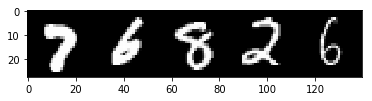

In [16]:
# Create sample to test that function is working
img, label = create_numbers(x_train, y_train, return_label=True)
plt.imshow(img, cmap='gray')
print label

#### Define a Python Generator to create an unlimited amount of training examples

In [17]:
def generator(numbers, number_labels, batch_size=32):
    """
    This generator receives mnist digits and labels and returns a batch for training

    Input:
    numbers - array with mnist images.
    number_labels - array with mnist labels.

    Arguments:
    batch_size - size of the mini batch

    Output:
    X_train and y_train
    """
    while True:  # Loop forever so the generator never terminates

        images = []
        labels = []

        for batch_sample in range(batch_size):
            img, label = create_numbers(numbers, number_labels, return_label=True)
            
            # Here we will convert the label to a format that Keras API can process:
            n_label = np.zeros((5, 11), dtype='int')
            for i, digit in enumerate(label):
                if digit == ".":
                    n_digit = 10
                else:
                    n_digit = int(digit)

                n_label[i][n_digit] = 1
                

            images.append(img)
            #labels.append(label)
            labels.append(n_label)

        X_train = np.array(images)
        if len(X_train.shape) == 3:
            X_train = np.expand_dims(X_train, -1)

        y_temp = np.array(labels)
        
        y1 = y_temp[:, 0, :]
        y2 = y_temp[:, 1, :]
        y3 = y_temp[:, 2, :]
        y4 = y_temp[:, 3, :]
        y5 = y_temp[:, 4, :]

        yield X_train, [y1, y2, y3, y4, y5]

In [18]:
def convert_label(label):
    n_label = ""
    for digit in label:
        if np.argmax(digit) == 10:
            n_digit = "."
        else:
            n_digit = str(np.argmax(digit))
        n_label += n_digit
    return n_label

In [19]:
# Create samples to test the generator
i = 0
for a, b in generator(x_train, y_train, batch_size=16): 
    test_imgs = a
    test_lbls = b
    
    i += 1
    
    if i > 1:
        break

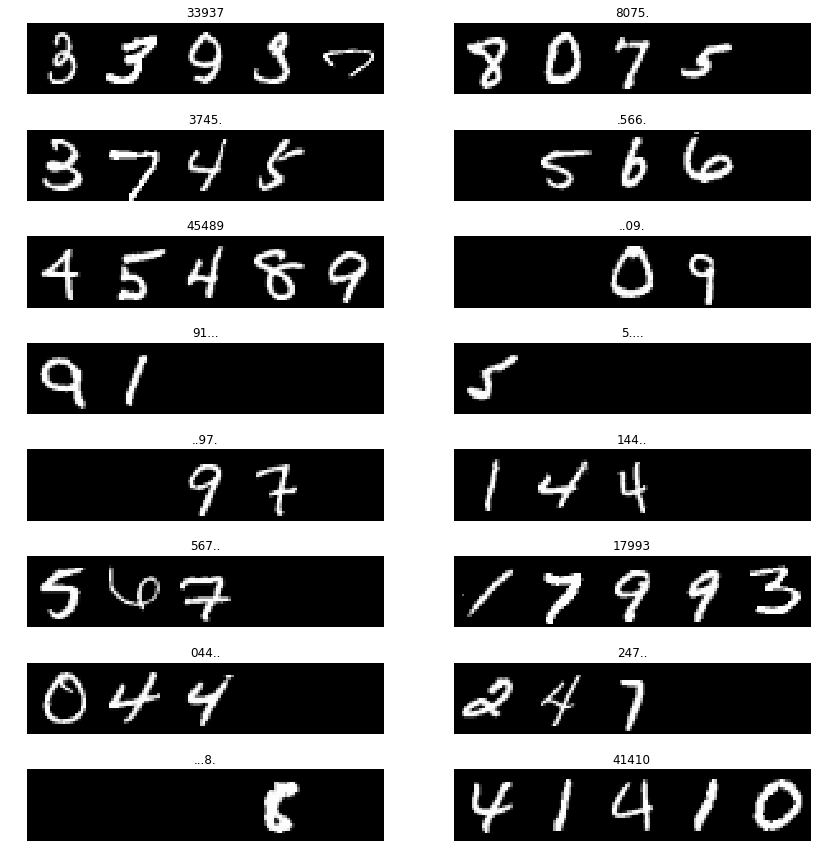

In [22]:
rows_to_plot = 8
cols_to_plot = 2

f = plt.figure(figsize=(12, 12))

for i in range(16):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.title(convert_label(np.vstack((test_lbls[0][i], test_lbls[1][i], test_lbls[2][i], 
                                                test_lbls[3][i],test_lbls[4][i]))))
    plt.imshow(test_imgs[i][:, :, 0], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

#### End-to-end model

In [23]:
# Based on Model from: http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf

def get_model(input_shape=(28, 28*5, 3), p=0.5, n_class=11):

    inputs = Input(((input_shape[0], input_shape[1], input_shape[2])))
    
    x = BatchNormalization()(inputs)
    x = Convolution2D(48, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p/4)(x)
    
    x = BatchNormalization()(x)
    x = Convolution2D(64, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p/4)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(128, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p/2)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(160, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p/2)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p)(x)
    
    # I had to remove this part because the input size we have is too small for a network this deep.
    # Another alternative would have been change the maxpool strides.
    
    #x = BatchNormalization()(x)
    #x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    #x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    #x = Dropout(p)(x)

    #x = BatchNormalization()(x)
    #x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    #x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    #x = Dropout(p)(x)
    
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x) # I also reduced the number of activations
    x = Dense(1024, activation='relu')(x)
    
    c1 = Dense(n_class, activation='softmax')(x)
    c2 = Dense(n_class, activation='softmax')(x)
    c3 = Dense(n_class, activation='softmax')(x)
    c4 = Dense(n_class, activation='softmax')(x)
    c5 = Dense(n_class, activation='softmax')(x)
    
    output = [c1, c2, c3, c4, c5]
    
    model = Model(inputs=inputs, outputs=output)

    return model


In [24]:
def convert_output(model_output):
    model_output = np.array(model_output).swapaxes(0, 1)
    labels = []
    for output in model_output:
        label = convert_label(output)
        labels.append(label)

    return labels

In [25]:
model = get_model(input_shape=(28, 28*5, 1))

In [26]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 28, 140, 1)    0                                            
____________________________________________________________________________________________________
batch_normalization_7 (BatchNorm (None, 28, 140, 1)    4                                            
____________________________________________________________________________________________________
conv2d_7 (Conv2D)                (None, 28, 140, 48)   1248                                         
____________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)   (None, 14, 70, 48)    0                                            
___________________________________________________________________________________________

#### Overfit on small sample data

In [643]:
# Overfit small data to ensure model can learn
optimizer = Adam(lr=1e-3)
model.compile(optimizer, loss='categorical_crossentropy')
model.fit(test_imgs, test_lbls, epochs=50, verbose=0)
teste_out = model.predict(test_imgs)

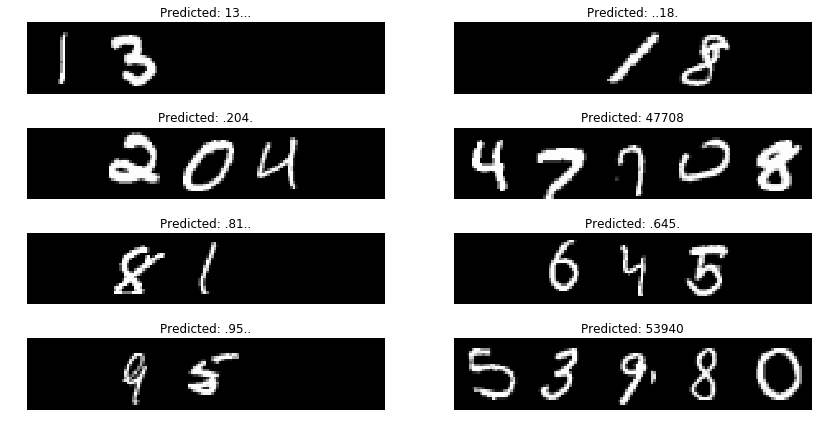

In [746]:
output = convert_output(teste_out)

rows_to_plot = 4
cols_to_plot = 2

f = plt.figure(figsize=(12, 6))

for i, (pred, img) in enumerate(zip(output, test_imgs)):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.title("Predicted: " + pred)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Train the model

In [27]:
model = get_model(input_shape=(28, 28*5, 1))
optimizer = Adam(lr=1e-3)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

trn_generator = generator(x_train, y_train, batch_size=128)
val_generator = generator(x_test, y_test, batch_size=128)

In [28]:
model.fit_generator(trn_generator,
                    epochs=2,
                    steps_per_epoch=780,
                    validation_data=val_generator,
                    validation_steps=780,
                    verbose=1)

Epoch 1/2
780/780 [==============================] - 275s - loss: 1.4524 - dense_17_loss: 0.3055 - dense_18_loss: 0.3452 - dense_19_loss: 0.3534 - dense_20_loss: 0.2870 - dense_21_loss: 0.1614 - dense_17_categorical_accuracy: 0.8933 - dense_18_categorical_accuracy: 0.8785 - dense_19_categorical_accuracy: 0.8748 - dense_20_categorical_accuracy: 0.8995 - dense_21_categorical_accuracy: 0.9463 - val_loss: 3.0698 - val_dense_17_loss: 0.4606 - val_dense_18_loss: 0.6168 - val_dense_19_loss: 0.9328 - val_dense_20_loss: 0.5511 - val_dense_21_loss: 0.5084 - val_dense_17_categorical_accuracy: 0.8238 - val_dense_18_categorical_accuracy: 0.8238 - val_dense_19_categorical_accuracy: 0.7766 - val_dense_20_categorical_accuracy: 0.7908 - val_dense_21_categorical_accuracy: 0.7947
Epoch 2/2
780/780 [==============================] - 219s - loss: 0.1396 - dense_17_loss: 0.0292 - dense_18_loss: 0.0347 - dense_19_loss: 0.0317 - dense_20_loss: 0.0271 - dense_21_loss: 0.0168 - dense_17_categorical_accuracy: 0.

#### Evaluate

In [398]:
# Create a test set with 1,000 examples

i = 0
for test_set, test_labels in generator(x_train, y_train, batch_size=1000): 

    i += 1

    if i > 1:
        break

In [399]:
model.evaluate(test_set, test_labels)

1000/1000 [==============================] - 2s     


[0.079091373045928781,
 0.012106221029651351,
 0.029453999262419529,
 0.020494234301149845,
 0.008694140136009082,
 0.0083427751858034752,
 0.999,
 0.996,
 0.995,
 0.998,
 0.997]

In [400]:
test_pred = model.predict(test_set)

In [401]:
test_pred_labels = convert_output(test_pred)
test_true_labels = convert_output(test_labels)

Predicted:  6698.
Ground Truth:  6698.


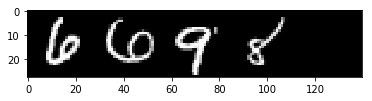

In [402]:
ref = 800
print "Predicted: ", test_pred_labels[ref]
print "Ground Truth: ", test_true_labels[ref]

plt.imshow(test_set[ref][:, :, 0], cmap='gray')

We can see that the individual predictions are above 99.5% for all digits, but the true error will be higher than that since any digit that we misclassify will be enough to render our prediction useless.

So we need to evaluate the whole prediction as either right or wrong.

In [407]:
accuracy = accuracy_score(test_true_labels, test_pred_labels)

In [408]:
print "Accuracy: ", accuracy*100, "%"

Accuracy:  98.5 %


#### Save  and load our model

In [24]:
#model.save_weights('./models/step1.h5')

In [9]:
model.load_weights('./models/step1.h5')

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

Before I started coding the first step, it was good to think about the purpose of the synthetic dataset in the pipeline. Generally speaking, in an academic study, the datasets are somewhat standardized, and benchmarks for new models are established on top of this "clean data" - in commercial applications, however, that is not the norm. Labeled data to train your models are expensive to obtain, and the best approach is to often train a model in a similar dataset if available and then fine-tune it to the new problem you are trying to solve.

Having said that, we want to make our synthetic data as close as possible to the data you expect to feed your model when you fine-tune it. So the obvious thing is to have a look at a few images from the SVHN dataset and then come up with a "proxy" synthetic dataset.

Upon exploring the SVHN dataset we notice that the numbers are not always exactly centered, and they appear in several different colors, skew and rotation. 

Our synthetic dataset was created by first randomly choosing a number length between 1 and 5 digits, followed by another random decision as to where in the image we would like the sequence to appear (centered, skip first character, etc...) and then finally randomly pulling N digits from the MNIST training dataset.

When creating the labels I decided to use "." to represent blank spaces to help when visually investigating the dataset.

Examples were thoroughly provided on the notebook.


** End-To-End Deep CNN model **

In the project instructions there were several recommended approaches to create a pipeline to solve our problem, the one that I found more interesting is based on [[1]](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf "Multi-digit Number Recognition from Street View
Imagery using Deep Convolutional Neural Networks") where the authors proposed an end-to-end solution to this problem that does not involve breaking down the problem into localization, segmentation and recognition in different steps.

As Goodfellow et al. describe in their work:
>Recognizing arbitrary multi-character text in unconstrained natural photographs is a hard problem. In this paper, we address an equally hard sub-problem in this domain viz. recognizing arbitrary multi-digit numbers from Street View imagery.
Traditional approaches to solve this problem typically separate out the localization, segmentation, and recognition steps. In this paper we propose a unified approach that integrates these three steps via the use of a deep convolutional neural network that operates directly on the image pixels

Inspired by the great results they displayed in their study and an elegant solution that would learn from these images without the assistance of a digit localizer, I decided to replicate their work for this pipeline.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**
The model proposed by Goodfellow et al. is the following:
>Our best architecture consists of eight convolutional hidden layers, one locally connected hidden layer, and two densely connected hidden layers. All connections are feedforward and go from one layer to the next (no skip connections). The first hidden layer contains maxout units (Goodfellow et al., 2013) (with three filters per unit) while the others contain rectifier units (Jarrett et al., 2009; Glorot et al., 2011). The number of units at each spatial location in each layer is [48, 64, 128, 160] for the first four layers and 192 for all other locally connected layers. The fully connected layers contain 3,072 units each.


The dimensions of our synthetic images are 28 x 140 x 1 (MNIST dimensions are 28 x 28 and we concatenated up to 5 of them together) and the 11 layer the authors used in their work was too deep for our data, so some modification was needed.

I could have just removed a few of the MaxPooling layers, but since this problem was simpler to solve I decided to completely remove the last two convolutional blocks and the first locally connected hidden layer. I also included BatchNormalization before every convolutional layer and reduced the number of activations on the fully connected layers to 1024.

The final version can be seen below

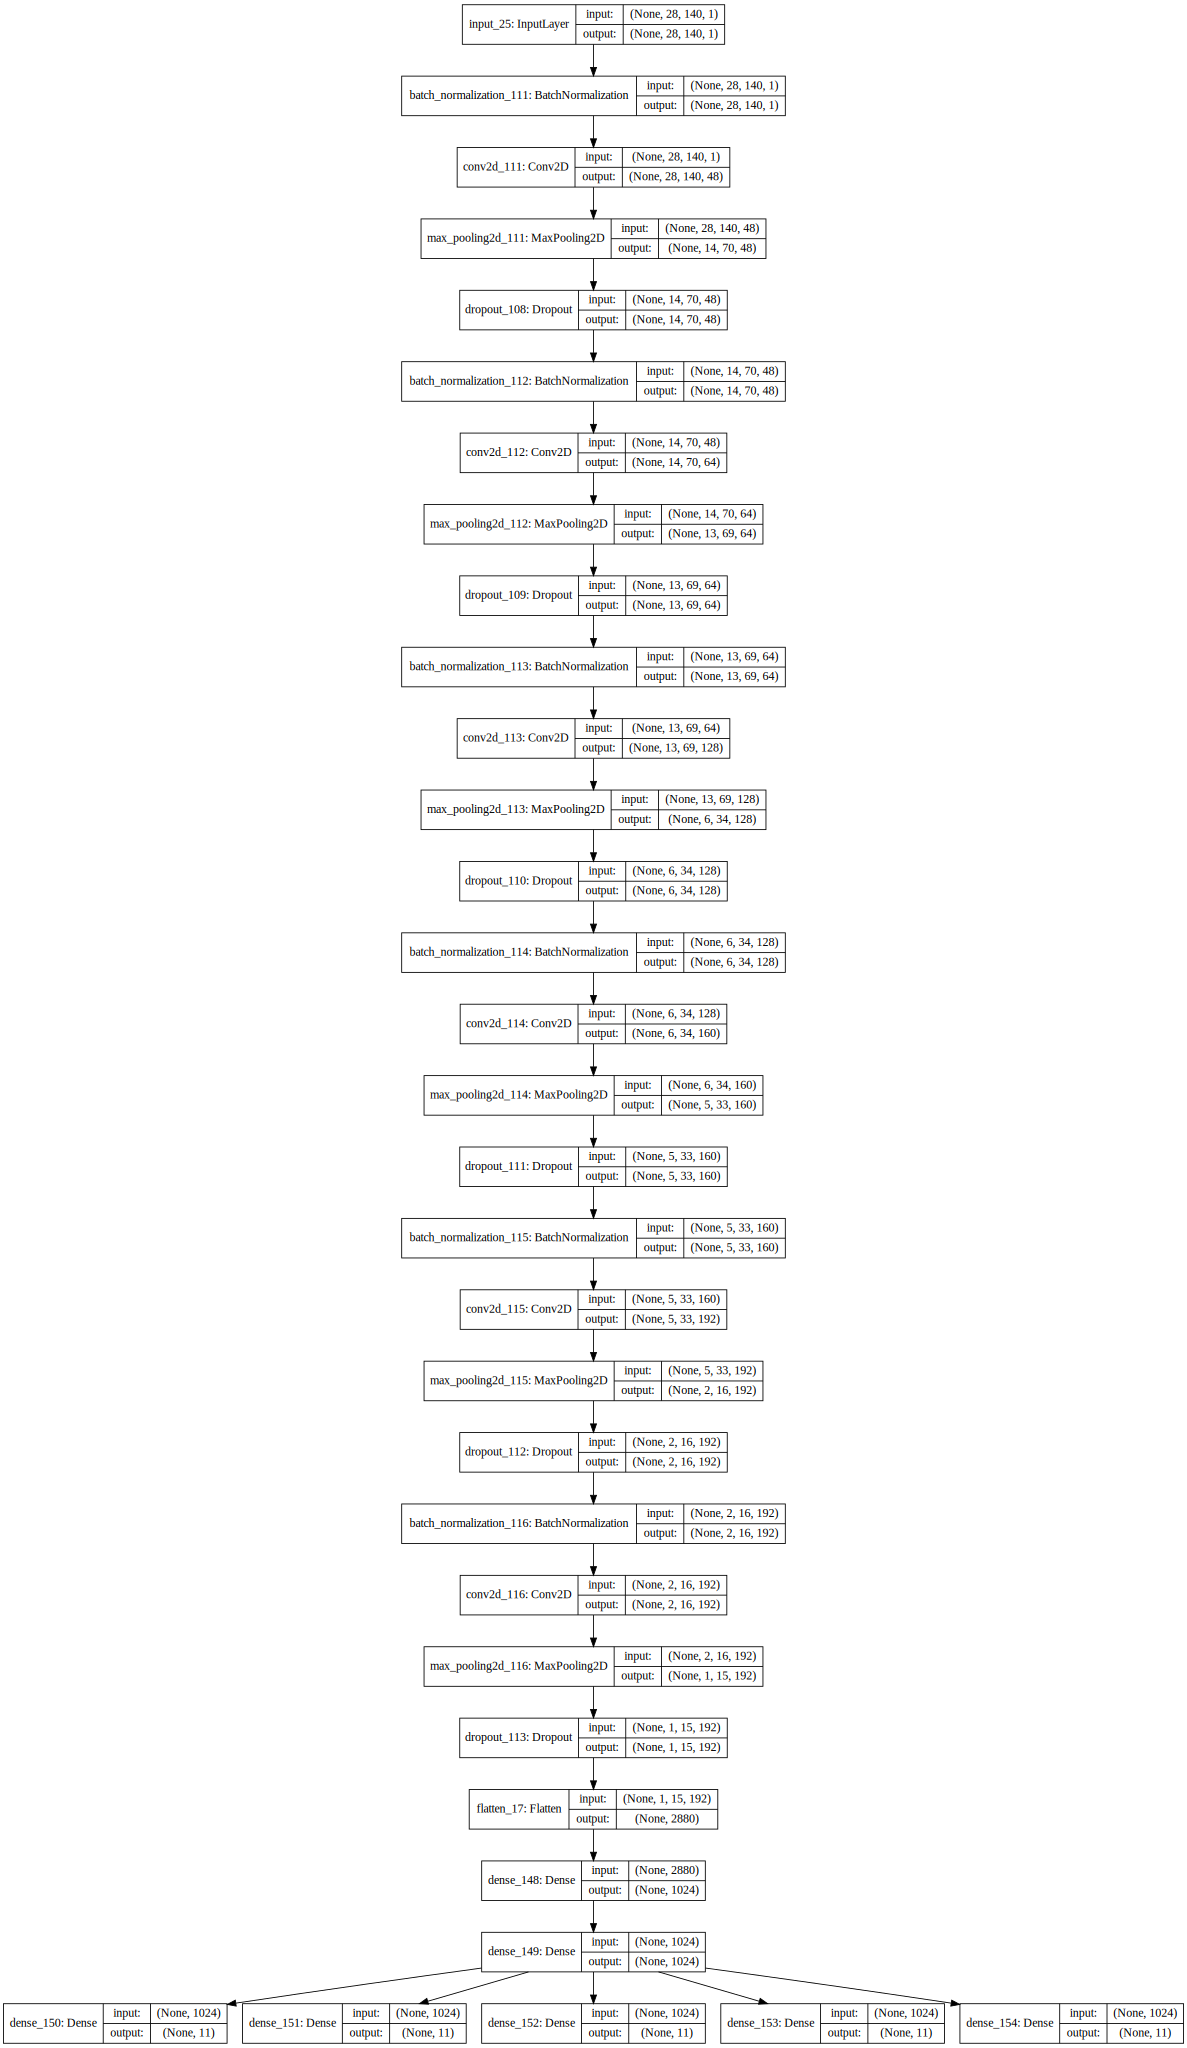

In [717]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

The first step was to create a function that would output an image of up to 5 digits, randomly extracted from the MNIST dataset and it's label - For the sake of visualization I decided to use a "." to represent blank cells, that way we can validate if the position of the prediction is in the right place. The full implementation can be found in this notebook, under the function **create_numbers**.

The next step was to create a python generator that would output several of these images and their labels in a format that Keras API would be able to process. This can be found under the function **generator** provided above.

The python generator leverages the **create_numbers** function in order to provide us with a virtually unlimited training set. A thorough explanation of how it works can be seen below:

```python
def generator(numbers, number_labels, batch_size=32):

    while True:  # Loop forever so the generator never terminates
    
        # define blank lists that will be filled in the for loop
        images = []
        labels = []
        
        # loop for as many iterations as you want your batch size to be
        for batch_sample in range(batch_size):
            img, label = create_numbers(numbers, number_labels, return_label=True)
            
            # After calling our create_numbers function we are basically done, but unfortunately
            # Keras needs the labels to be one-hot encoded so from here on we just convert
            # our labels into arrays of n_label dimensions that has 1 for the column to which class
            # the sample belongs and 0 everywhere else.
            
            # define a label set with 5 rows (number of digits) and 11 columns (0-9 digits + blank)
            n_label = np.zeros((5, 11), dtype='int')
            for i, digit in enumerate(label):
                if digit == ".":
                    n_digit = 10
                else:
                    n_digit = int(digit)

                n_label[i][n_digit] = 1
                
        # in the function we manipulate the numbers furter to ensure compatibility with Keras' API 

        # return randomly generated image and list of one-hot encoded labels
        yield X_train, [y1, y2, y3, y4, y5]
```

Samples were provided right after each function was created.

With this generator we can have an unlimited amount of data to train our model. My first step was to train the model with a very small dataset (8 samples) that allowed me to quickly identify mistakes and fix the model without the burden of waiting for the long training time. At this stage I also made sure the model could overfit the small sample.

When you have unlimited training data, the only problem you need to worry about is for how long to train. In general, it's difficult to end up over fitting to your data if your synthetic data is carefully crafted like ours.

I used a mini-batch size of 128 samples, a number large enough that also fit in my GPU memory, and decided that every epoch should consist of approximately 100k images (as it would in theory allow the model to see each possibility at least once, although in practice we can't be sure) after just two epochs of training our validation accuracy was already above 99.5% for each individual digit so I stopped training.

Measuring accuracy in that way is not recommended, because if our output has any of the digits wrong, the information is useless. So I converted the predicted digits back to string and compared with the ground truth strings generated for 1,000 random images from the validation set and the accuracy this time was 98.5%.

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



#### Data Exploration

In [29]:
path = '/home/bruno/Documents/eLearning/udacity/Digit-Recognition'
dataset_path = '/media/bruno/Data/Datasets/SVHN/'

In [30]:
train_filenames = glob(dataset_path + '/train/*.png')

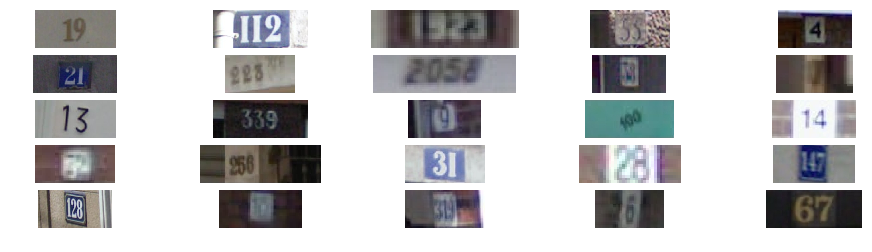

In [31]:
rows_to_plot = 5
cols_to_plot = 5

f = plt.figure(figsize=(16, 4))

for i, fn in enumerate(np.random.choice(len(train_filenames), rows_to_plot * cols_to_plot)):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.imshow(Image.open(train_filenames[fn], mode='r'))
    plt.axis('off')

plt.show()

From this first exploration we can see that it's going to be a lot harder to train a model that performs well on this dataset. The numbers appear in different colors, distortions, skews and conditions (e.g. blurred images).

Differently than our synthetic dataset, street numbers in real life don't have a random distribution like the ones we created. Most streets are short ones and we should expect to see a lot more numbers with less 3 or less digits than with 4 or 5.

Let's take a look at how the length of digits is distributed in our training set.

In [16]:
def readAndSaveMetadata(filepath):
    # Forked from https://discussions.udacity.com/t/how-to-deal-with-mat-files/160657/3
    
    # Load the given MatLab file
    f = h5py.File(filepath, 'r')
    fn = filepath.split('/')[-1]
    
    # Create our empty dictionary
    metadata= {}
    metadata['height'] = []
    metadata['label'] = []
    metadata['left'] = []
    metadata['top'] = []
    metadata['width'] = []
    
    # define a function to pass to h5py's visititems() function
    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(f[obj[k][0]][0][0])
        metadata[name].append(vals)
    
    # Add information to metadata
    for item in f['/digitStruct/bbox']:
        f[item[0]].visititems(print_attrs)
    
    # Save to a pickle file
    pickle_file = fn + '.pickle'
    try:
      pickleData = open(pickle_file, 'wb')
      pickle.dump(metadata, pickleData, pickle.HIGHEST_PROTOCOL)
      pickleData.close()
    except Exception as e:
      print 'Unable to save data to', pickle_file, ':', e
      raise

In [58]:
#readAndSaveMetadata(dataset_path + 'train_digitStruct.mat')
#readAndSaveMetadata(dataset_path + 'test_digitStruct.mat')

In [72]:
f = open('train_digitStruct.mat.pickle', 'r')
trn_data = pickle.load(f)
trn_data = pd.DataFrame.from_dict(trn_data)

f = open('test_digitStruct.mat.pickle', 'r')
tst_data = pickle.load(f)
tst_data = pd.DataFrame.from_dict(tst_data)

In [18]:
trn_label_len = []
for label in trn_data['label']:
    label_len = len(label)
    trn_label_len.append(label_len)
    

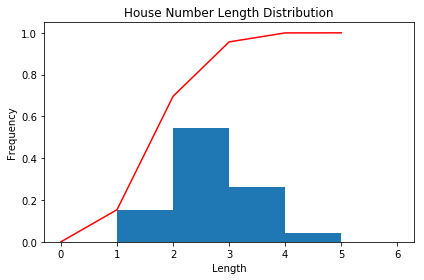

In [19]:
count, bins, patches = plt.hist(trn_label_len, bins=range(1,7), normed=True )

plt.plot(np.concatenate(([0], np.cumsum(count))), 'r' )
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('House Number Length Distribution')
plt.tight_layout()

As we expected over 95% of our sample has 3 or less digits. This will probably impact the performance of our algorithm when detecting longer street numbers.

#### Image pre-processing

The authors of the paper we are basing this work on have suggested the following pre-processing steps:

- Based on the provided bounding boxes, find another box that will contain all digits on the image

- Expand this bounding box by 30% in each direction and crop the image to this bounding box

- Resize the cropped image to 64 x 64 pixels

- Random crop a 54 x 54 sample from the cropped image

This will be implemented inside a generate_crop function that will later on be called by our generator.

In [33]:
def generate_crop(filepath, dataframe, expand_by=0.3, verbose=0, crop_sz=(64, 64), random_crop=True):
    """
    This function expects a filepath of an image and will return either a 64 x 64 crop
    or a 54 x 54 random crop of the street number depending on the random_crop parameter.
    
    """
    # 1 - open the image and store img dimensions
    img = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_h = img.shape[0]
    img_w = img.shape[1]

    if verbose>0:
        print "img_h: ", img_h, "    img_w: ", img_w, "\n"

    # 2 - find bounding box for whole street number
    fn = filepath.split('/')[-1].split('.')[0]

    left = np.min(dataframe.loc[int(fn) - 1].left)
    top = np.min(dataframe.loc[int(fn) - 1].top)
    bottom = (np.max(dataframe.loc[int(fn) - 1].top) + np.max(dataframe.loc[int(fn) - 1].height))
    right = (np.max(dataframe.loc[int(fn) - 1].left) + np.max(dataframe.loc[int(fn) - 1].width))

    if verbose>0:
        print "left: ", left, "    right: ", right, "    top: ", top, "    bottom: ", bottom, "\n"

    # 3 - Expand bounding box by X%
    mid_x = (left + right) // 2
    mid_y = (top + bottom) // 2
    new_h = np.abs(bottom - top) * (1 + expand_by)
    new_w = np.abs(right - left) * (1 + expand_by)

    if verbose>0:
        print "mid_x: ", mid_x, "    mid_y: ", mid_y, "    new_h: ", new_h, "    new_w: ", new_w, "\n"
    
    # New points will be determined by the calculations above and the original image size
    left = np.max((0, mid_x - new_w // 2)).astype(np.uint)
    right = np.min((img_w, mid_x + new_w // 2)).astype(np.uint)
    top = np.max((0, mid_y - new_h // 2)).astype(np.uint)
    bottom = np.min((img_h, mid_y + new_h // 2)).astype(np.uint)

    if verbose>0:
        print "n_left: ", left, "    n_right: ", right, "    n_top: ", top, "    n_bottom: ", bottom, "\n"
    
    # 4 - Crop image within bounding box
    cropped = img[top:bottom, left:right, :].copy()

    # 5 - Rescale to 64 x 64
    rescaled = cv2.resize(cropped, crop_sz)
    
    if random_crop:
        dx = np.random.randint(0, 10)
        dy = np.random.randint(0, 10)
        rescaled = rescaled[dx:dx+54, dy:dy+54, :]
    
    return rescaled

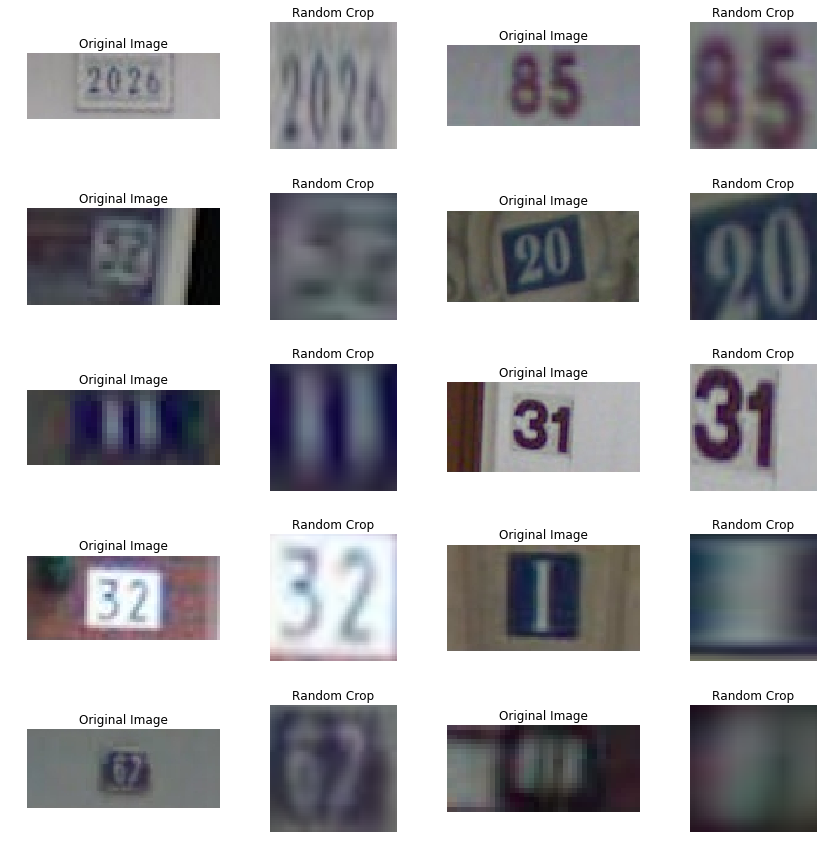

In [102]:
items_to_plot = 10

f = plt.figure(figsize=(12, 12))

i = 0
for fn in np.random.choice(len(train_filenames), items_to_plot):
    # Plot original
    f.add_subplot(items_to_plot // 2, 4, i+1)
    plt.title('Original Image')
    plt.imshow(Image.open(train_filenames[fn], mode='r'))
    plt.axis('off')
    i += 1

    # Plot cropped
    f.add_subplot(items_to_plot // 2, 4, i+1)
    plt.title('Random Crop')
    plt.imshow(generate_crop(train_filenames[fn], trn_data))
    plt.axis('off')
    i += 1

plt.tight_layout()
plt.show()

#### Test run with the previous model

Now that we can isolate the numbers from the rest of the image, we can pass this image to our first model and see how it performs. In order to do that we will need to scale them to 28 x 140 and grayscale - since this is how our model was trained.

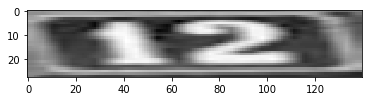

In [62]:
test_img = generate_crop(train_filenames[35], trn_data, crop_sz=(140, 28), random_crop=False)
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
plt.imshow(test_img, cmap='gray')

In [63]:
test_img = np.expand_dims(test_img, -1)

In [64]:
test_pred = model.predict(np.expand_dims(test_img, 0))
test_pred_labels = convert_output(test_pred)
print "Predicted: ", test_pred_labels

Predicted:  ['.777.']


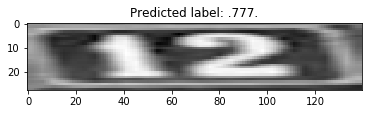

In [65]:
ref = 35
test_img = generate_crop(train_filenames[ref], trn_data, crop_sz=(140, 28), random_crop=False)
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
test_img = np.expand_dims(test_img, -1)
test_pred = model.predict(np.expand_dims(test_img, 0))
test_pred_labels = convert_output(test_pred)

plt.imshow(test_img[:, :, 0], cmap='gray')
plt.title("Predicted label: " + test_pred_labels[0])

That's not a good indicator, I personally chose the above image as i expected it to be easier, as it's somewhat similar to what we have been using so far. Unfortunately because the two datasets have labels created in very different ways, it would be too time consuming to develop a compatibility layer just to prove that our current model is not doing a good job.

If we had reasons to believe it would perform well, it would probably be worth to invest time into doing that, but if it fails on the "easy" images, we will make a better use of our time if we train a new model.

The paper we are basing our work on trains the model using not only the 5 digits, but also the length of the digits, we will now define a function to get us this information for each sample in our dataset.

In [400]:
def get_label(filepath, dataframe, maxlength=5):
    """

    This function will return the categorical (one-hot) representation of 6 digits 
    that will be used to train our model.
    
    The first is the length of the house number for a given filepath and then one digit
    for each of the 5 possible spots we are trying to predict, with 0 being "more than 5" for length
    and blank for the individual digits.
    
    """

    fn = filepath.split('/')[-1].split('.')[0]

    label = dataframe.loc[int(fn) - 1].label

    l = np.zeros(maxlength+1)
    try:
        l[len(label)] = 1
    except:
        l[0] = 1

    y = np.zeros((5, 11), dtype=int)

    for i in range(5):
        try:
            y[i][int(label[i])] = 1
        except:
            y[i][0] = 1

    return [l, y[0], y[1], y[2], y[3], y[4]]

We also need to define a new function to convert back our label to a format we can understand

In [401]:
def new_convert_label(label):
    l = label[0]
    labels = label[1:]
    n_label = ""
    for digit in labels:
        if np.argmax(digit) == 0:
            n_digit = ""
        elif np.argmax(digit) == 10:
            n_digit = "0"
        else:
            n_digit = str(np.argmax(digit))
        n_label += n_digit
    return n_label

converted label:  38


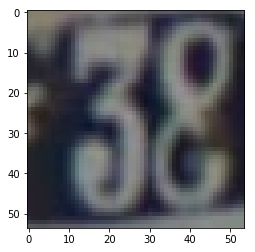

In [417]:
# Test if everything works
# print (get_label(train_filenames[100], trn_data))
print "converted label: ", new_convert_label(get_label(train_filenames[10], trn_data))
plt.imshow(generate_crop(train_filenames[10], trn_data))

#### Another Generator

Similarly to what we did on the first step, we will define a generator that will pass a random crop of the image and all the labels to our new model.

In [402]:
def new_generator(filepath_list, dataframe, batch_size=32, crop_sz=(64, 64),
                  shuffle_data=True, random_crop=True, return_labels=True):
    """
    This generator receives a lisit of filenames from the SVHN dataset and a pandas dataframe
    with the label information and returns a random crop of the image and the one-hot encoding
    of the labels so we can pass it directly to Keras.

    Input:
    filepath_list - list with path to SVHN images.
    dataframe - pandas dataframe with information about each image.

    Arguments:
    batch_size - size of the mini batch

    Outputs:
    X_train and y_train
    """

    num_samples = len(filepath_list)
    filelist = copy.copy(filepath_list)

    if shuffle_data:
        shuffle(filelist)

    while True:  # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = filelist[offset:offset + batch_size]

            if shuffle_data:
                shuffle(batch_samples)

            images = []
            length = []
            digits = []

            for batch_sample in batch_samples:
                img = generate_crop(batch_sample, dataframe, crop_sz=crop_sz, random_crop=random_crop)
                y = np.zeros((5, 11), dtype='int')
                [l, y[0, :], y[1, :], y[2, :], y[3, :], y[4, :]] = get_label(batch_sample, dataframe)
            
                images.append(img)
                length.append(l)
                digits.append(y)

            X_train = np.array(images)
            if len(X_train.shape) == 3:
                X_train = np.expand_dims(X_train, -1)

            y_temp = np.array(digits)
            l = np.array(length)

            y1 = y_temp[:, 0, :]
            y2 = y_temp[:, 1, :]
            y3 = y_temp[:, 2, :]
            y4 = y_temp[:, 3, :]
            y5 = y_temp[:, 4, :]
            
            if return_labels:
                yield X_train, [l, y1, y2, y3, y4, y5]
            else:
                yield X_train

In [536]:
# Create samples to test the generator
i = 0
for a, b in new_generator(train_filenames, trn_data, batch_size=25): 
    test_imgs = a
    test_lbls = b
    
    i += 1
    
    if i > 1:
        break

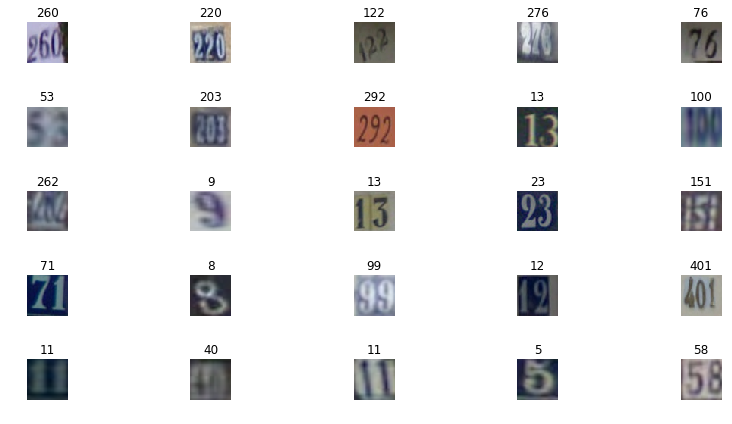

In [537]:
rows_to_plot = 5
cols_to_plot = 5

f = plt.figure(figsize=(12, 6))

for i in range(rows_to_plot * cols_to_plot):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.title(new_convert_label([test_lbls[0][i], test_lbls[1][i], test_lbls[2][i], 
                                 test_lbls[3][i], test_lbls[4][i], test_lbls[5][i]]))
    plt.imshow(test_imgs[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Model

This time we can define the model exactly as proposed on the literature, given that our input images are also with the same dimension.

In [66]:
# Based on Model from: http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf

def get_new_model(input_shape=(54, 54, 3), p=0.5, n_class=11, n_len=6):

    inputs = Input(((input_shape[0], input_shape[1], input_shape[2])))
    
    x = BatchNormalization()(inputs)
    x = Convolution2D(48, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p/4)(x)
    
    x = BatchNormalization()(x)
    x = Convolution2D(64, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p/4)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(128, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p/2)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(160, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p/2)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p)(x)
    
    x = BatchNormalization()(x)
    x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p)(x)
    
    x = Flatten()(x)
    x = Dense(3072, activation='relu')(x)
    x = Dense(3072, activation='relu')(x)

    l = Dense(n_len, activation='softmax')(x)
    c1 = Dense(n_class, activation='softmax')(x)
    c2 = Dense(n_class, activation='softmax')(x)
    c3 = Dense(n_class, activation='softmax')(x)
    c4 = Dense(n_class, activation='softmax')(x)
    c5 = Dense(n_class, activation='softmax')(x)
    
    output = [l, c1, c2, c3, c4, c5]
    
    model = Model(inputs=inputs, outputs=output)

    return model

In [67]:
new_model = get_new_model()

In [360]:
new_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 54, 54, 3)     0                                            
____________________________________________________________________________________________________
batch_normalization_21 (BatchNor (None, 54, 54, 3)     12                                           
____________________________________________________________________________________________________
conv2d_21 (Conv2D)               (None, 54, 54, 48)    3648                                         
____________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D)  (None, 27, 27, 48)    0                                            
___________________________________________________________________________________________

In [405]:
def new_convert_output(model_output):
    l = model_output[0]
    digits = np.array(model_output[1:]).swapaxes(0, 1)
    labels = []
    for i in range(len(l)):
        label = new_convert_label(([l[i]], digits[i, 0, :], digits[i, 1, :],
                                  digits[i, 2, :], digits[i, 3, :], digits[i, 4, :]))
        labels.append(label)

    return labels

#### Overfit new model on small sample data

In [363]:
optimizer = Adam(lr=1e-3)
new_model.compile(optimizer, loss='categorical_crossentropy')
new_model.fit(test_imgs, test_lbls, epochs=1000, verbose=0)
teste_out = new_model.predict(test_imgs)

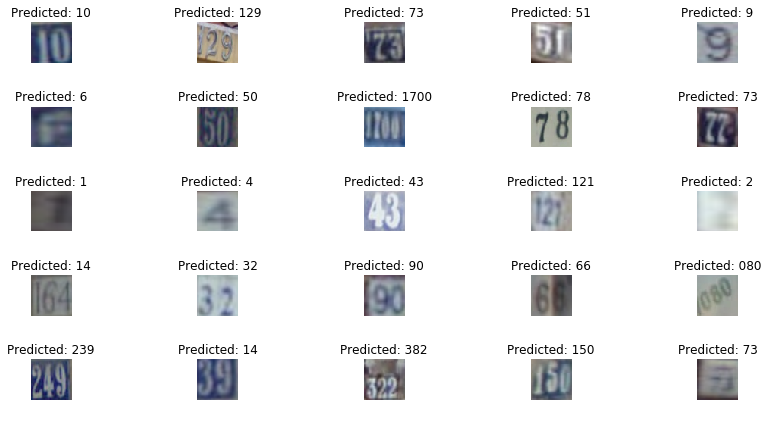

In [364]:
output = new_convert_output(teste_out)

rows_to_plot = 5
cols_to_plot = 5

f = plt.figure(figsize=(12, 6))

for i, (pred, img) in enumerate(zip(output, test_imgs)):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.title("Predicted: " + pred)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

This time the model required 1,000 epochs on the sample dataset to get to a "reasonable" point. It's still not overfitting completely, but it's learning.

#### Train the model

In [367]:
# Split data into training and validation, using 80% for training and 20% for validation:
trn_filenames, val_filenames = train_test_split(train_filenames, test_size=0.2)

In [666]:
new_model = get_new_model()
optimizer = Adam(lr=1e-3)
new_model.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
callbacks = [ModelCheckpoint('./models/new_model.{epoch:02d}-{val_loss:.2f}.hdf5')]

trn_generator = new_generator(trn_filenames, trn_data, batch_size=128)
val_generator = new_generator(val_filenames, trn_data, batch_size=128)

In [679]:
new_model.fit_generator(trn_generator,
                    epochs=5,
                    steps_per_epoch=200,
                    validation_data=val_generator,
                    validation_steps=200,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/5
200/200 [==============================] - 113s - loss: 0.9175 - dense_88_loss: 0.0667 - dense_89_loss: 0.2490 - dense_90_loss: 0.2772 - dense_91_loss: 0.2305 - dense_92_loss: 0.0911 - dense_93_loss: 0.0031 - dense_88_categorical_accuracy: 0.9806 - dense_89_categorical_accuracy: 0.9287 - dense_90_categorical_accuracy: 0.9157 - dense_91_categorical_accuracy: 0.9283 - dense_92_categorical_accuracy: 0.9705 - dense_93_categorical_accuracy: 0.9996 - val_loss: 0.9950 - val_dense_88_loss: 0.1150 - val_dense_89_loss: 0.2614 - val_dense_90_loss: 0.2960 - val_dense_91_loss: 0.2140 - val_dense_92_loss: 0.1055 - val_dense_93_loss: 0.0032 - val_dense_88_categorical_accuracy: 0.9684 - val_dense_89_categorical_accuracy: 0.9293 - val_dense_90_categorical_accuracy: 0.9261 - val_dense_91_categorical_accuracy: 0.9412 - val_dense_92_categorical_accuracy: 0.9686 - val_dense_93_categorical_accuracy: 0.9998
Epoch 2/5
200/200 [==============================] - 109s - loss: 0.9377 - dense_88_loss: 0.

#### Save  and load our model

In [696]:
#new_model.save_weights('./models/step2.h5')

In [406]:
new_model.load_weights('./models/step2.h5')

In [671]:
teste_out = new_model.predict(test_imgs)

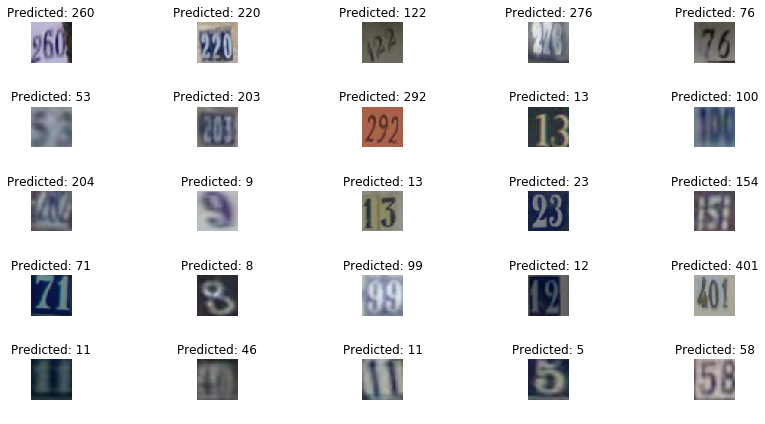

In [672]:
output = new_convert_output(teste_out)

rows_to_plot = 5
cols_to_plot = 5

f = plt.figure(figsize=(12, 6))

for i, (pred, img) in enumerate(zip(output, test_imgs)):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.title("Predicted: " + pred)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Evaluate the model

In [393]:
tst_filenames = glob(dataset_path + '/test/*.png')

In [624]:
tst_imgs = []
tst_labels = []
for filename in tst_filenames:
    img = generate_crop(filename, tst_data, crop_sz=(54, 54), random_crop=False)
    lbl = get_label(filename, tst_data)
    n_lbl = new_convert_label(lbl)
    tst_labels.append(n_lbl)
    tst_imgs.append(img)

tst_imgs = np.array(tst_imgs)

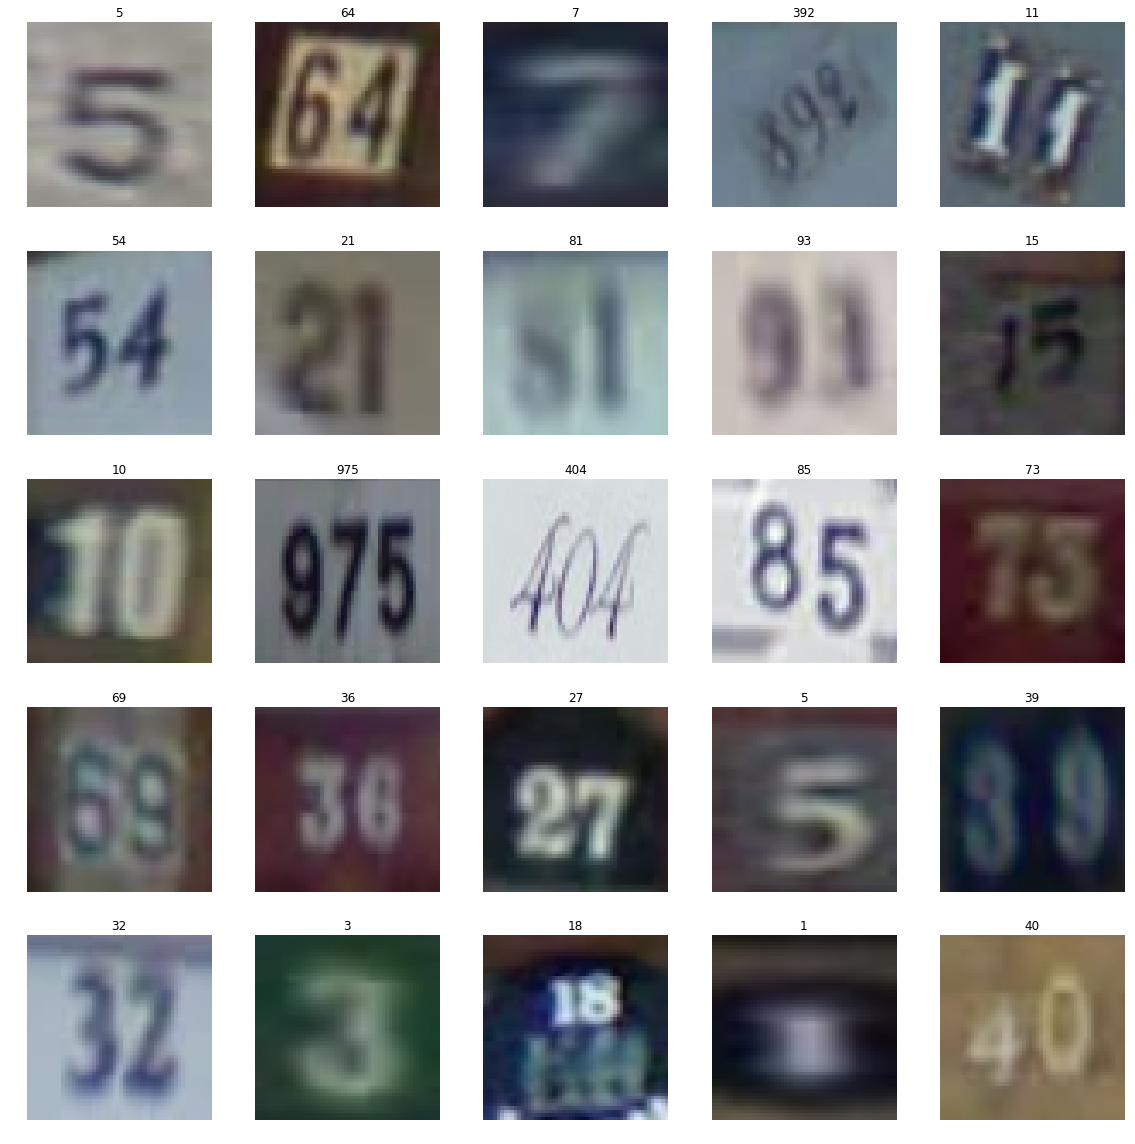

In [627]:
# Check that we are getting the imgs and labels correctly
rows_to_plot = 5
cols_to_plot = 5

f = plt.figure(figsize=(16, 16))

for i, fn in enumerate(np.random.choice(len(tst_filenames), rows_to_plot * cols_to_plot)):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.imshow(tst_imgs[fn])
    plt.title(tst_labels[fn])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [593]:
#tst_generator = new_generator(tst_filenames, tst_data, batch_size=128, crop_sz=(54, 54),
#                              shuffle_data=False, random_crop=False, return_labels=False)

In [604]:
#tst_pred = new_model.predict_generator(tst_generator, steps=len(tst_filenames) // 128 + 1)

In [692]:
tst_pred = new_model.predict(tst_imgs, batch_size=128)

In [693]:
pred_labels = new_convert_output(tst_pred)

In [694]:
tst_accuracy = accuracy_score(tst_labels, pred_labels)

In [695]:
print "Accuracy: ", np.round(tst_accuracy*100, 1), "%"

Accuracy:  83.0 %


This is still significantly below the 98% of human accuracy, but in Goodfellow et al. they trained 10 models in parallel for 6 days to achieve human level accuracy. Our version was trained for 20 epochs, where in each epoch it would see approximately 10 different crops of each image.

If we continued to optimize the model weights, I am positive we would have better results.

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

### Testing the first model on the SVHN dataset

At this point I realized that I should have also explored the labels from the SVHN dataset and not only the images when creating our synthetic dataset.

The fact that the labels were incompatible made large-scaling impossible without developing a label-conversion function and before doing that I decided to manually test the model in a few selected images to see if it was worth investing the time to convert the labels.

The only processing steps on the new images were to scale to 28 x 140 pixels and convert to gray scale, as that is how our model was trained.

Surprisingly the model was not able to generalize at all, it was incorrect on 100% of the test images. I was obviously expecting a decrease in performance but 0% accuracy was definitely an unpleasant surprise.

Due to the incompatibility of labels and input size between datasets, fine tuning would be more difficult than training a new model. Too bad, as we ended up missing an important part of the purpose of the synthetic dataset, although all this was not completely wasted, we validated that the model architecture we chose is right for the problem at hand.

### Training 2.0

The SVHN data set provides coordinates of bounding boxes for each digit in an image, but since the purpose of our pipeline is to identify the whole street number in one shot, we needed to pass a cropped version of the image with all numbers in it, and not much more.

We followed the suggested training methodology from Goodfellow et al.

- Based on the provided bounding boxes, find another box that will contain all digits on the image

- Expand this bounding box by 30% in each direction and crop the image to this bounding box

- Resize the cropped image to 64 x 64 pixels

- Random crop a 54 x 54 sample from the cropped image

Training was again assisted by a python generator, that randomly cropped the 64 x 64 pixel image into 54 x 54 patches, aiming to increase the amount of training data. At this time 20% of the dataset was put aside for validation.

The accuracy of the model on a realistic dataset is 83%, but the accuracy was still improving when we decided to interrupt the optimization.

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

Knowing that we would need to train a new model from scratch gave me the freedom to implement some improvements to the architecture. I added back to the model the two convolutional blocks that were initially removed, I also increased the number of hidden units in the last two fully connected layers and added a new branch of softmax classifier to predict the length of the sequence of digits.

Aside from these few adjustments, the model architecture is very similar to our first one and can be seen below:


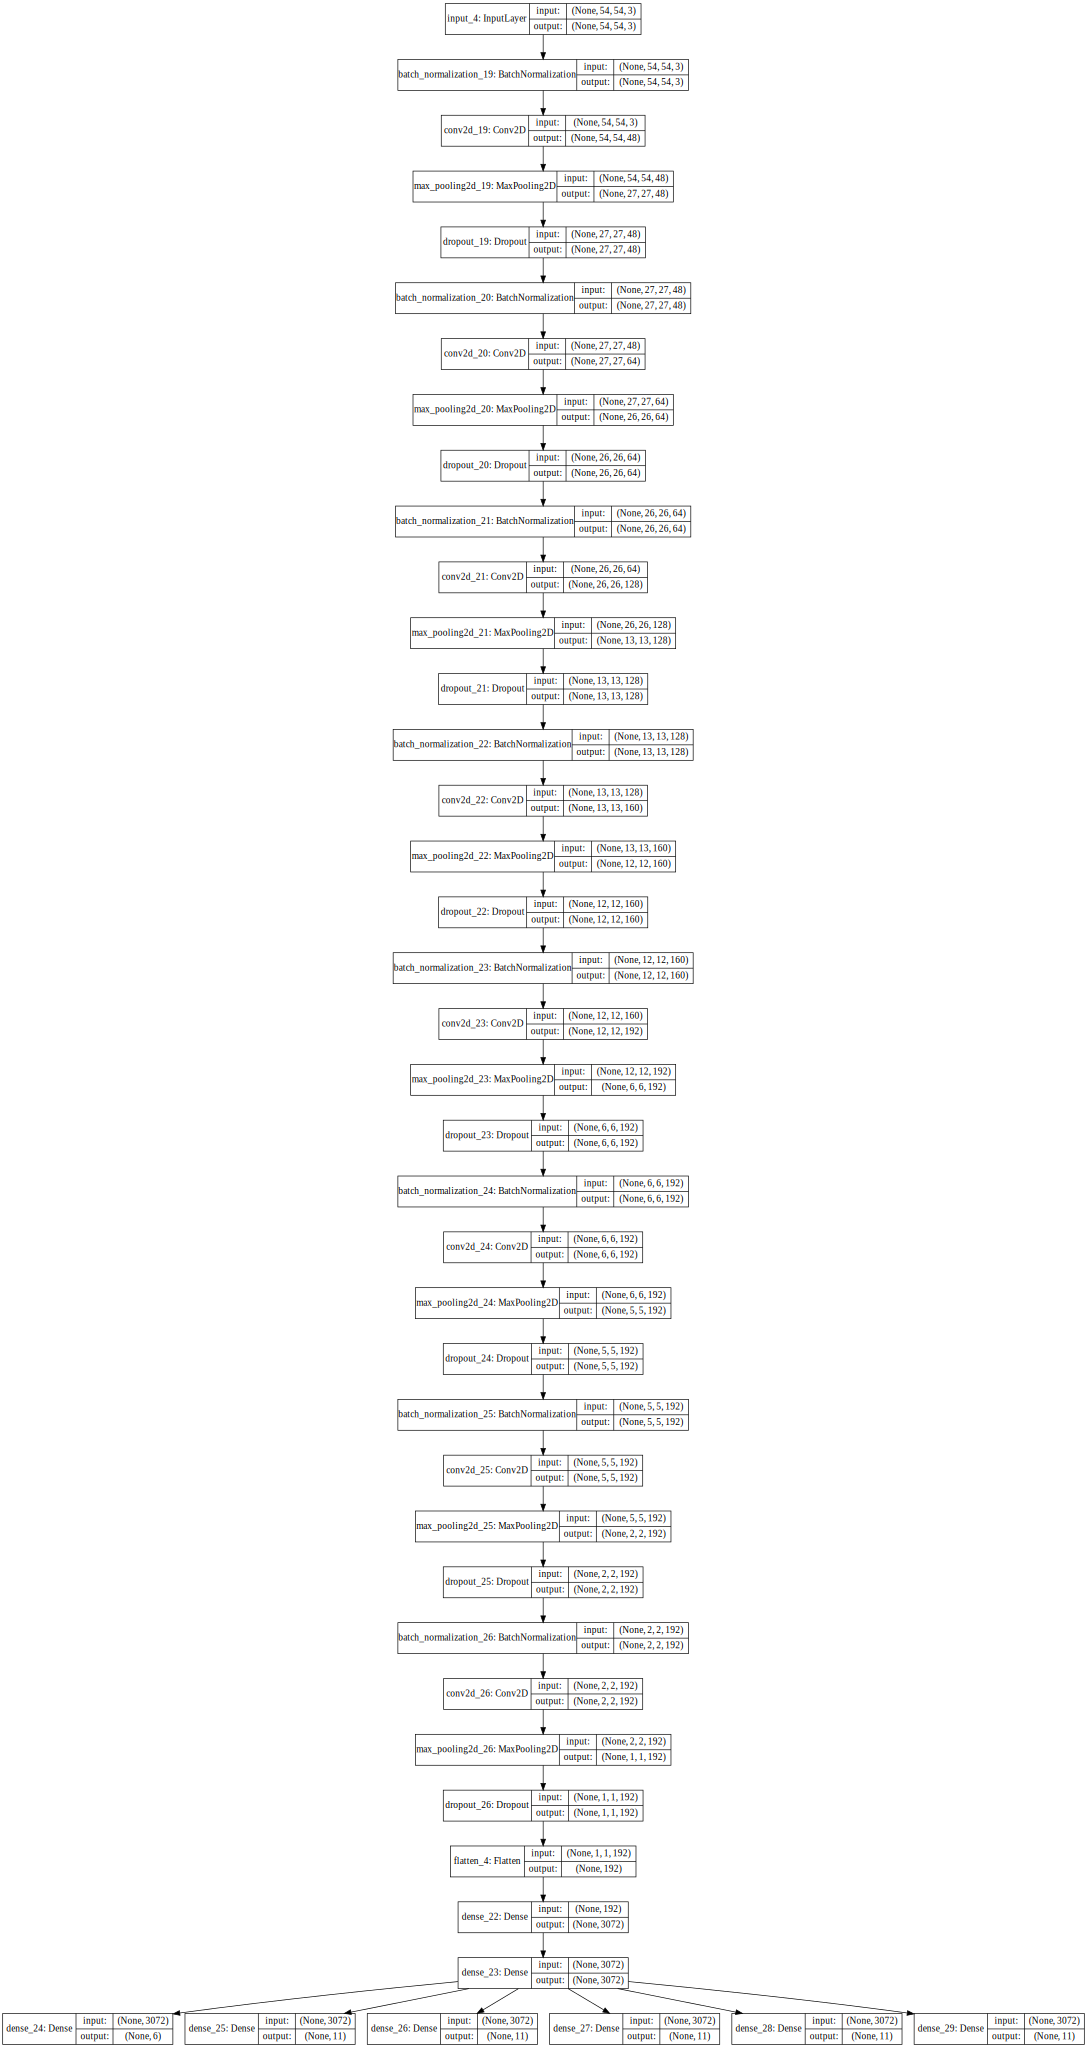

In [100]:
SVG(model_to_dot(new_model, show_shapes=True).create(prog='dot', format='svg'))

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

My initial result was probably very close to 0, as I tried to use the pre-trained weights of my model on step 1, but didn't have an easy way of converting the labels of the second dataset to measure it's performance. Since the initial exploration was already indicating that it would have a poor performance, I decided to train a larger model, following the suggestion of the literature we based this work on.

At the end of 20 epochs the accuracy of our model was 83% - still significantly below human accuracy, but it is a strong indicator that the model is able to learn and if trained for longer, it could achieve results similar to what was observed by the authors of the paper.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



In [444]:
new_images = []
new_filenames = []

filelist = os.listdir('./data/')

for file in filelist:

    try:
        img = cv2.imread('./data/' + file, cv2.IMREAD_COLOR)
    except:
        img = None

    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (54, 54))
        new_images.append(img)
        new_filenames.append(file)

In [445]:
new_images = np.array(new_images)
test_new_preds = new_model.predict(new_images)
new_pred_labels = new_convert_output(test_new_preds)

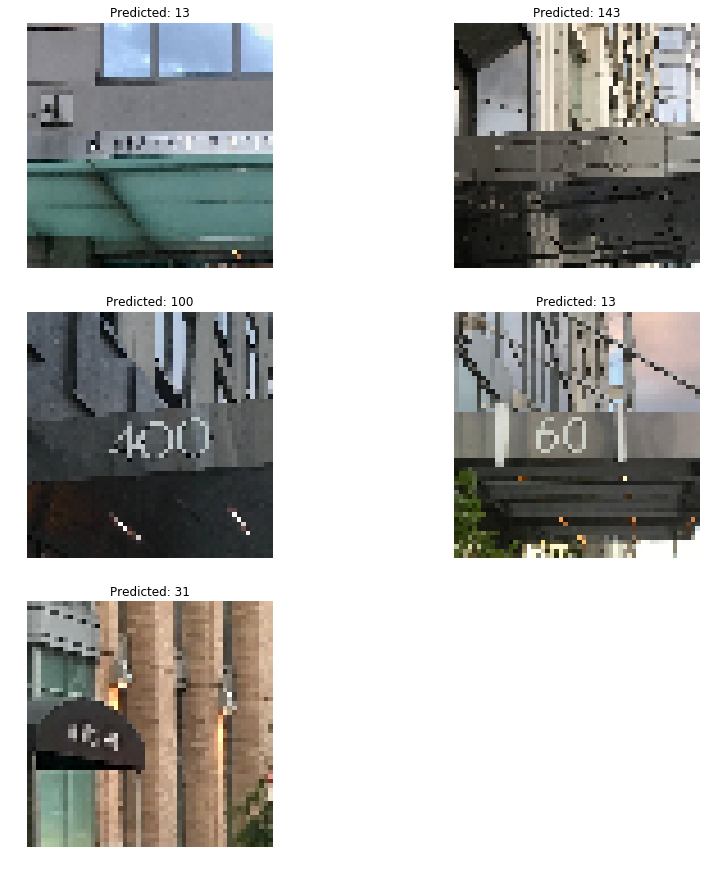

In [446]:
rows_to_plot = 5
cols_to_plot = 2

f = plt.figure(figsize=(12, 20))

for i, (pred, img) in enumerate(zip(new_pred_labels, new_images)):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.title("Predicted: " + pred)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

We will now pass on the cropped numbers to see if it gets any better

In [447]:
new_images = []
new_filenames = []

filelist = os.listdir('./data/small/')

for file in filelist:

    try:
        img = cv2.imread('./data/small/' + file, cv2.IMREAD_COLOR)
    except:
        img = None

    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (54, 54))
        new_images.append(img)
        new_filenames.append(file)

In [448]:
new_images = np.array(new_images)
test_new_preds = new_model.predict(new_images)
new_pred_labels = new_convert_output(test_new_preds)

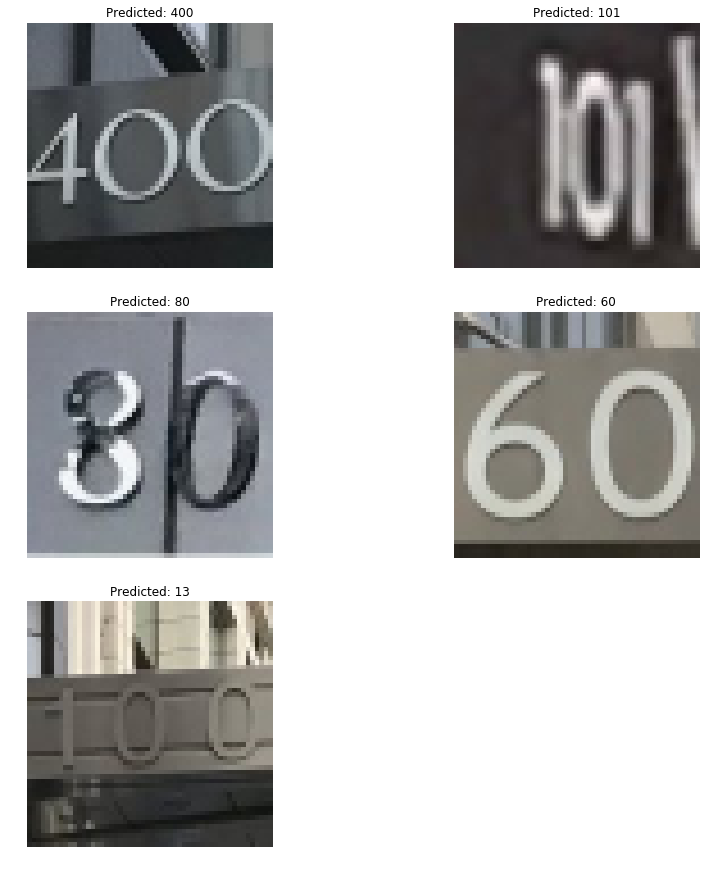

In [449]:
rows_to_plot = 5
cols_to_plot = 2

f = plt.figure(figsize=(12, 20))

for i, (pred, img) in enumerate(zip(new_pred_labels, new_images)):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.title("Predicted: " + pred)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

Ah! Much better!

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

The pictures were taking from a long distance, and when they were scaled down the algorithm failed to predict in all 5 cases. When we passed the cropped number it actually had a performance similar to what we found above ~80% (4 out of 5 numbers were correctly labeled)

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

Our model only performed well when the images were cropped in a similar way as the images we passed on to the model during training. Which is in line with what should be expected. We trained the model using an easier dataset where the numbers were already located for it and it's unreasonable to expect that the model would be able to generalize to images with a lot more information.

Another issue is that we trained the model on a super small patch of image 54 x 54 pixels, and to use an image that was captured with a smartphone we needed to downsize it so much that any detail was lost. 

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



In [5]:
trn_filenames, val_filenames = train_test_split(train_filenames, test_size=0.2)

#### Get bounding boxes to train

In [69]:
def get_bbox(filepath, dataframe, verbose=0):
    """
    This function expects a filepath of an image and a dataframe with information for the bounding boxes
    and will return a larger bounding box that wraps all the digits on the house number.
    
    """

    # 1 - find bounding box for whole street number
    fn = filepath.split('/')[-1].split('.')[0]

    left = np.min(dataframe.loc[int(fn) - 1].left).astype(np.uint)
    top = np.min(dataframe.loc[int(fn) - 1].top).astype(np.uint)
    bottom = (np.max(dataframe.loc[int(fn) - 1].top) + np.max(dataframe.loc[int(fn) - 1].height)).astype(np.uint)
    right = (np.max(dataframe.loc[int(fn) - 1].left) + np.max(dataframe.loc[int(fn) - 1].width)).astype(np.uint)

    if verbose>0:
        print "left: ", left, "    right: ", right, "    top: ", top, "    bottom: ", bottom, "\n"

    
    return left, right, top, bottom

In [70]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[0], bb[2]), bb[1] - bb[0], bb[3] - bb[2], color=color, fill=False, lw=3)

def show_bb_raw(filepath, dataframe):
    bb = get_bbox(filepath, dataframe)
    plt.imshow(Image.open(filepath, mode='r'))
    plt.gca().add_patch(create_rect(bb))

def show_bb(img, bb, bb_2=None):
    plt.imshow(img)
    plt.gca().add_patch(create_rect(bb))
    if bb_2 is not None:
        plt.gca().add_patch(create_rect(bb_2, 'yellow'))

/home/bruno/anaconda3/envs/py27_dl/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in ulong_scalars
  from ipykernel import kernelapp as app


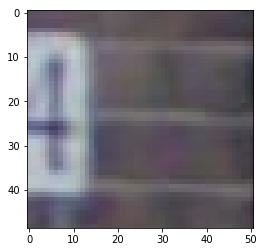

In [74]:
show_bb_raw(val_filenames[5587], trn_data)

#### Rescaling images and bounding boxes

Since we have images with various dimensions, we will need to rescale them to the same size in order to feed our model. We will also need to apply the same transformation to the bounding boxes coordinates.

In [75]:
def resize_imgs(filepath, dataframe, return_bbox=True, target_sz=(64, 64), verbose=0):

    # 1 - open the image and store img dimensions
    img = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_h = float(img.shape[0])
    img_w = float(img.shape[1])

    if verbose>0:
        print "img_h: ", img_h, "    img_w: ", img_w, "\n"
        print "tgt_sz_0: ", target_sz[0], "    tgt_sz_1: ", target_sz[1], "\n"

    # 2 - resize image
    rescaled = cv2.resize(img, target_sz)
    
    if return_bbox:

        # 3 - find bounding box for whole street number
        fn = filepath.split('/')[-1].split('.')[0]

        left = np.min(dataframe.loc[int(fn) - 1].left)
        top = np.min(dataframe.loc[int(fn) - 1].top)
        bottom = (np.max(dataframe.loc[int(fn) - 1].top) + np.max(dataframe.loc[int(fn) - 1].height))
        right = (np.max(dataframe.loc[int(fn) - 1].left) + np.max(dataframe.loc[int(fn) - 1].width))
        
        if verbose>0:
            print "left: ", left, "    right: ", right, "    top: ", top, "    bottom: ", bottom, "\n"

        # 4 - Convert bounding box to new image size
        h_ratio = img_h / target_sz[0]
        w_ratio = img_w / target_sz[1]

        if verbose>0:
            print "h_ratio: ", h_ratio, "    w_ratio: ", w_ratio, "\n"
        
        left = np.max((0, np.floor_divide(left, w_ratio)))
        right = np.min((target_sz[1], np.floor_divide(right, w_ratio)))
        top = np.max((0, np.floor_divide(top, h_ratio)))
        bottom = np.min((target_sz[0], np.floor_divide(bottom, h_ratio)))

        if verbose>0:
            print "left: ", left, "    right: ", right, "    top: ", top, "    bottom: ", bottom, "\n"

        return rescaled, [left, right, top, bottom]

    else:
        return rescaled

In [38]:
"""trn_bbox_imgs = []
trn_bbox_box = []
target_sz = (64, 64)

for filename in trn_filenames:
    img, bb = resize_imgs(filename, trn_data, target_sz=(64, 64), verbose=0)
    trn_bbox_imgs.append(img)
    trn_bbox_box.append(bb)

trn_bbox_box = np.array(trn_bbox_box)
trn_bbox_imgs = np.array(trn_bbox_imgs)"""

In [35]:
"""val_bbox_imgs = []
val_bbox_box = []
target_sz = (64, 64)

for filename in val_filenames:
    img, bb = resize_imgs(filename, trn_data, target_sz=(64, 64), verbose=0)
    val_bbox_imgs.append(img)
    val_bbox_box.append(bb)

val_bbox_box = np.array(val_bbox_box)
val_bbox_imgs = np.array(val_bbox_imgs)"""

In [41]:
"""# Save images and bboxes to pickle
f = open('trn_filenames.pickle', 'wb')
pickle.dump(trn_filenames, f, pickle.HIGHEST_PROTOCOL)
f.close()

f = open('val_filenames.pickle', 'wb')
pickle.dump(val_filenames, f, pickle.HIGHEST_PROTOCOL)
f.close()

f = open('trn_bbox_box.pickle', 'wb')
pickle.dump(trn_bbox_box, f, pickle.HIGHEST_PROTOCOL)
f.close()

f = open('trn_bbox_imgs.pickle', 'wb')
pickle.dump(trn_bbox_imgs, f, pickle.HIGHEST_PROTOCOL)
f.close()

f = open('val_bbox_box.pickle', 'wb')
pickle.dump(val_bbox_box, f, pickle.HIGHEST_PROTOCOL)
f.close()

f = open('val_bbox_imgs.pickle', 'wb')
pickle.dump(val_bbox_imgs, f, pickle.HIGHEST_PROTOCOL)
f.close()"""

In [79]:
# Load Pickles
f = open('trn_filenames.pickle', 'r')
trn_filenames = pickle.load(f)
f.close()

f = open('val_filenames.pickle', 'r')
val_filenames = pickle.load(f)
f.close()

f = open('trn_bbox_box.pickle', 'r')
trn_bbox_box = pickle.load(f)
f.close()

f = open('trn_bbox_imgs.pickle', 'r')
trn_bbox_imgs = pickle.load(f)
f.close()

f = open('val_bbox_box.pickle', 'r')
val_bbox_box = pickle.load(f)
f.close()

f = open('val_bbox_imgs.pickle', 'r')
val_bbox_imgs = pickle.load(f)
f.close()

trn_bbox_box = np.array(trn_bbox_box, dtype=float)
trn_bbox_imgs = np.array(trn_bbox_imgs, dtype=float)
val_bbox_box = np.array(val_bbox_box, dtype=float)
val_bbox_imgs = np.array(val_bbox_imgs, dtype=float)

In [80]:
def cvt_bbox(bbox):
    """
    Input: bounding box: Left, Right, Top, Bottom
    Output: x0, y0, width, height
    """
    
    left, right, top, bottom = bbox
    
    x0 = left
    y0 = top
    width = right - left
    height = bottom - top
    
    return x0, y0, width, height

In [77]:
#trn_bbox_box_new = [cvt_bbox(box) for box in trn_bbox_box]
trn_bbox_imgs /= 255
trn_bbox_imgs -= 0.5

#val_bbox_box_new  = [cvt_bbox(box) for box in val_bbox_box]
val_bbox_imgs /= 255
val_bbox_imgs -= 0.5

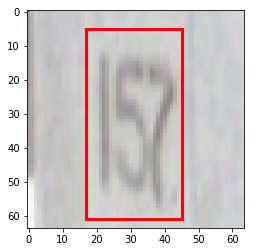

In [82]:
ref=777
show_bb(trn_bbox_imgs[ref], trn_bbox_box[ref])

#### First attempt: Use the image and the coordinates of the bounding boxes

In [74]:
inputs = Input(((64, 64, 3)))

x = BatchNormalization()(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Dropout(0.25)(x)

x = BatchNormalization()(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Dropout(0.5)(x)

x = BatchNormalization()(x)
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = Dropout(0.5)(x)

x = Flatten()(x)
x_bb = Dense(4, name='bb')(x)

#### Overfit small sample

In [75]:
loc_model = Model([inputs], x_bb,)
loc_model.compile(Adam(lr=0.001), loss='mse', metrics=['mae'])

In [76]:
loc_model.fit(trn_bbox_imgs[0:5], trn_bbox_box[0:5], batch_size=5, epochs=50, verbose=0)

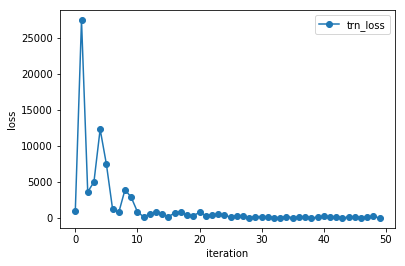

In [77]:
plt.plot(loc_model.history.history['loss'], '-o')
plt.legend(['trn_loss'], loc='upper right')
plt.xlabel('iteration')
plt.ylabel('loss')

#### Train

In [78]:
loc_model = Model([inputs], x_bb,)
loc_model.compile(Adam(lr=0.001), loss='mse', metrics=['mae'])

In [79]:
loc_model.fit(trn_bbox_imgs, trn_bbox_box, batch_size=32, epochs=5,
              validation_data=(val_bbox_imgs, val_bbox_box), verbose=1)

Train on 26721 samples, validate on 6681 samples
Epoch 1/5
26721/26721 [==============================] - 128s - loss: 137.6092 - mean_absolute_error: 5.8193 - val_loss: 280.4828 - val_mean_absolute_error: 13.9940
Epoch 2/5
26721/26721 [==============================] - 126s - loss: 25.9522 - mean_absolute_error: 3.8438 - val_loss: 167.7546 - val_mean_absolute_error: 10.7965
Epoch 3/5
26721/26721 [==============================] - 126s - loss: 20.9355 - mean_absolute_error: 3.4088 - val_loss: 159.4912 - val_mean_absolute_error: 10.5842
Epoch 4/5
26721/26721 [==============================] - 126s - loss: 19.5479 - mean_absolute_error: 3.2973 - val_loss: 23.3824 - val_mean_absolute_error: 3.6011
Epoch 5/5
26721/26721 [==============================] - 125s - loss: 18.7609 - mean_absolute_error: 3.2379 - val_loss: 29.4293 - val_mean_absolute_error: 4.1567


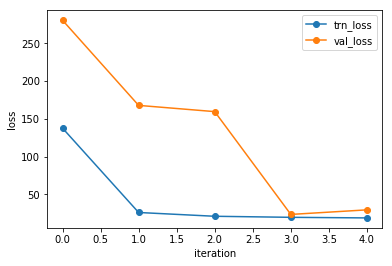

In [80]:
plt.plot(loc_model.history.history['loss'], '-o')
plt.plot(loc_model.history.history['val_loss'], '-o')
plt.legend(['trn_loss', 'val_loss'], loc='upper right')
plt.xlabel('iteration')
plt.ylabel('loss')

In [93]:
pred_box = loc_model.predict(val_bbox_imgs)

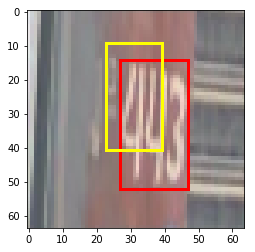

In [102]:
val_ref=8
show_bb((val_bbox_imgs[val_ref] + 0.5) * 255, val_bbox_box[val_ref], pred_box[val_ref])

#### Second attempt: Transform bounding boxes into image masks and use a better loss function

In [83]:
def get_mask_seg(img, bbox, value=1.):
    
    img_mask = np.zeros_like(img[:,:,0])
    
    x_min, x_max, y_min, y_max = bbox
    
    x_min = np.round(x_min,0).astype(np.uint8)
    x_max = np.round(x_max,0).astype(np.uint8)
    y_min = np.round(y_min,0).astype(np.uint8)
    y_max = np.round(y_max,0).astype(np.uint8)

    img_mask[y_min:y_max, x_min:x_max]= 1. * value

    img_mask = np.reshape(img_mask,(np.shape(img_mask)[0],np.shape(img_mask)[1],1))
    
    return img_mask

In [84]:
def plot_im_mask(im,im_mask):
    ### Function to plot image mask 
    
    im = np.array(im,dtype=np.uint8)
    im_mask = np.array(im_mask,dtype=np.uint8)
    plt.figure(figsize=(24,12))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
    plt.axis('off')
    plt.show();

In [85]:
loc_trn_mask = np.array([get_mask_seg(img,bbox, value=1.) for (img,bbox) in zip(trn_bbox_imgs, trn_bbox_box) ])

loc_val_mask = np.array([get_mask_seg(img,bbox, value=1.) for (img,bbox) in zip(val_bbox_imgs, val_bbox_box) ])

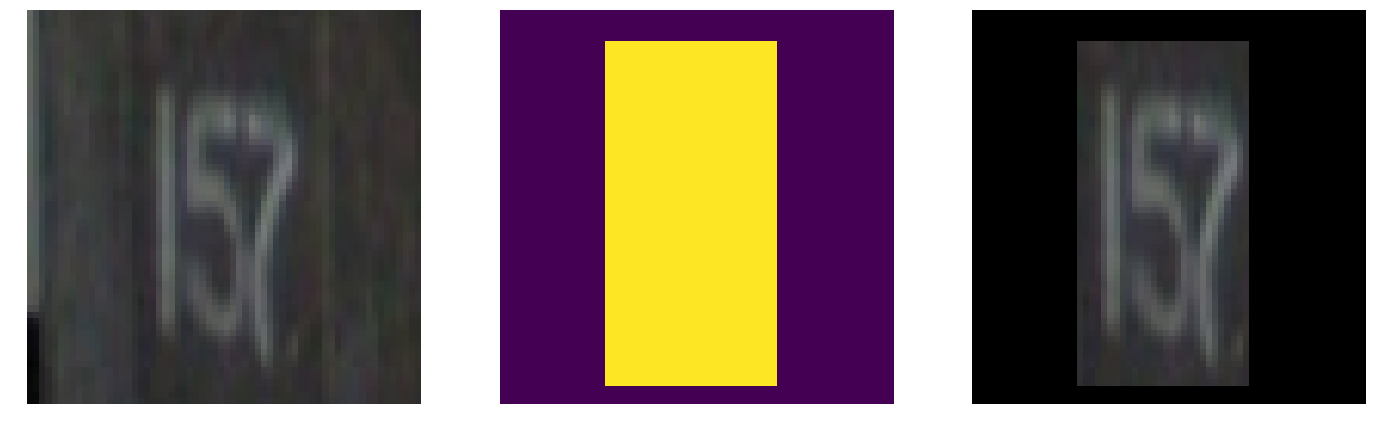

In [91]:
ref = 777
plot_im_mask(trn_bbox_imgs[ref], loc_trn_mask[ref] * 255.)

#### IOU Loss

In [92]:
### IOU or dice coeff calculation measures the similarity in both area and position of the two bounding boxes

def IOU_calc(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IOU_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

In [245]:
inputs2 = Input(((64, 64, 3)))

x = BatchNormalization()(inputs2)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Dropout(0.25)(x)

x = BatchNormalization()(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Dropout(0.5)(x)

x = BatchNormalization()(x)
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = Dropout(0.5)(x)

output2 = Convolution2D(1, 3, activation='sigmoid', padding='same')(x)

In [246]:
loc_model2 = Model([inputs2], output2,)
loc_model2.compile(Adam(lr=0.001), loss=IOU_loss, metrics=[IOU_calc])

#### Overfit small sample

In [271]:
loc_model2.fit(trn_bbox_imgs[0:5], loc_trn_mask[0:5], batch_size=5, epochs=10, verbose=1)

Epoch 1/10
5/5 [==============================] - 0s - loss: -0.9154 - IOU_calc: 0.9154
Epoch 2/10
5/5 [==============================] - 0s - loss: -0.9222 - IOU_calc: 0.9222
Epoch 3/10
5/5 [==============================] - 0s - loss: -0.9237 - IOU_calc: 0.9237
Epoch 4/10
5/5 [==============================] - 0s - loss: -0.9206 - IOU_calc: 0.9206
Epoch 5/10
5/5 [==============================] - 0s - loss: -0.9216 - IOU_calc: 0.9216
Epoch 6/10
5/5 [==============================] - 0s - loss: -0.9227 - IOU_calc: 0.9227
Epoch 7/10
5/5 [==============================] - 0s - loss: -0.9214 - IOU_calc: 0.9214
Epoch 8/10
5/5 [==============================] - 0s - loss: -0.9261 - IOU_calc: 0.9261
Epoch 9/10
5/5 [==============================] - 0s - loss: -0.9286 - IOU_calc: 0.9286
Epoch 10/10
5/5 [==============================] - 0s - loss: -0.9171 - IOU_calc: 0.9171


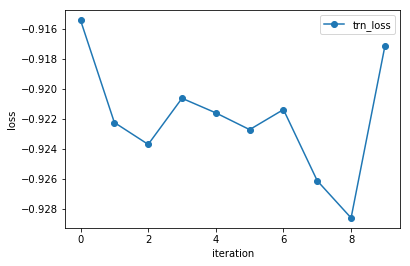

In [272]:
plt.plot(loc_model2.history.history['loss'], '-o')
plt.legend(['trn_loss'], loc='upper right')
plt.xlabel('iteration')
plt.ylabel('loss')

#### Train

In [278]:
loc_model2 = Model([inputs2], output2,)
loc_model2.compile(Adam(lr=0.001), loss=IOU_loss, metrics=[IOU_calc])

In [289]:
loc_model2.fit(trn_bbox_imgs, loc_trn_mask, batch_size=32, epochs=2,
              validation_data=(val_bbox_imgs, loc_val_mask), verbose=1)

Train on 26721 samples, validate on 6681 samples
Epoch 1/2
26721/26721 [==============================] - 136s - loss: -0.7290 - IOU_calc: 0.7290 - val_loss: -0.7379 - val_IOU_calc: 0.7379
Epoch 2/2
26721/26721 [==============================] - 136s - loss: -0.7359 - IOU_calc: 0.7359 - val_loss: -0.7379 - val_IOU_calc: 0.7379


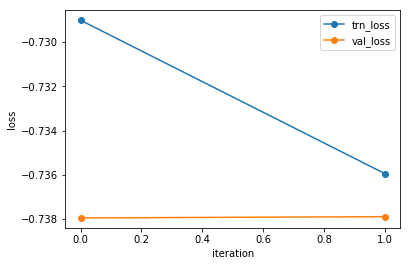

In [290]:
plt.plot(loc_model2.history.history['loss'], '-o')
plt.plot(loc_model2.history.history['val_loss'], '-o')
plt.legend(['trn_loss', 'val_loss'], loc='upper right')
plt.xlabel('iteration')
plt.ylabel('loss')

In [291]:
pred_box2 = loc_model2.predict(val_bbox_imgs)

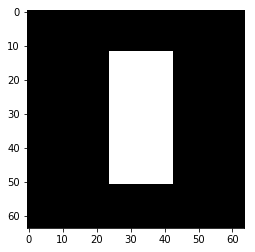

In [292]:
plt.imshow(loc_val_mask[2][:,:,0], cmap='gray')

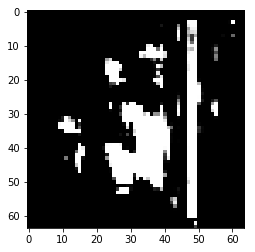

In [293]:
plt.imshow(pred_box2[2][:,:,0], cmap='gray')

#### Save  and load our model

In [24]:
#loc_model.save_weights('./models/locator.h5')

In [397]:
loc_model.load_weights('./models/locator.h5')

Still not amazing, but with this approach we can try fancier networks, like U-net.
[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

We will need to change it a little bit because our input image is a lot smaller than the ones they used on their model, but the concept will be the same.

In [93]:
def unet(input_shape=(64, 64, 3)):
    
    inputs = Input(((input_shape[0], input_shape[1], input_shape[2])))
    
    c_1 = Convolution2D(32, 3, activation='relu', padding='same', name='conv1_a')(inputs)
    c_1 = Convolution2D(32, 3, activation='relu', padding='same', name='conv1_b')(c_1)
    p_1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(c_1)

    c_2 = Convolution2D(64, 3, activation='relu', padding='same', name='conv2_a')(p_1)
    c_2 = Convolution2D(64, 3, activation='relu', padding='same', name='conv2_b')(c_2)
    p_2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(c_2)

    c_3 = Convolution2D(128, 3, activation='relu', padding='same', name='conv3_a')(p_2)
    c_3 = Convolution2D(128, 3, activation='relu', padding='same', name='conv3_b')(c_3)
    p_3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(c_3)

    c_4 = Convolution2D(256, 3, activation='relu', padding='same', name='conv4_a')(p_3)
    c_4 = Convolution2D(256, 3, activation='relu', padding='same', name='conv4_b')(c_4)
    p_4 = MaxPooling2D(pool_size=(2, 2), name='pool4')(c_4)

    c_5 = Convolution2D(512, 3, activation='relu', padding='same', name='conv5_a')(p_4)
    c_5 = Convolution2D(512, 3, activation='relu', padding='same', name='conv5_b')(c_5)

    up_6 = concatenate([UpSampling2D(size=(2, 2))(c_5), c_4])
    c_6 = Convolution2D(256, 3, activation='relu', padding='same', name='conv6_a')(up_6)
    c_6 = Convolution2D(256, 3, activation='relu', padding='same', name='conv6_b')(c_6)

    up_7 = concatenate([UpSampling2D(size=(2, 2))(c_6), c_3])
    c_7 = Convolution2D(128, 3, activation='relu', padding='same', name='conv7_a')(up_7)
    c_7 = Convolution2D(128, 3, activation='relu', padding='same', name='conv7_b')(c_7)

    up_8 = concatenate([UpSampling2D(size=(2, 2))(c_7), c_2])
    c_8 = Convolution2D(64, (3, 3), activation='relu', padding='same', name='conv8_a')(up_8)
    c_8 = Convolution2D(64, (3, 3), activation='relu', padding='same', name='conv8_b')(c_8)

    up_9 = concatenate([UpSampling2D(size=(2, 2))(c_8), c_1])
    c_9 = Convolution2D(32, (3, 3), activation='relu', padding='same', name='conv9_a')(up_9)
    c_9 = Convolution2D(32, (3, 3), activation='relu', padding='same', name='conv9_b')(c_9)

    c_10 = Convolution2D(1, 1, activation='sigmoid')(c_9)

    model = Model(inputs=[inputs], outputs=[c_10])

    return model

In [94]:
unet_model = unet()
unet_model.compile(Adam(lr=1e-4), loss=IOU_loss, metrics=[IOU_calc])

In [360]:
unet_model.fit(trn_bbox_imgs, loc_trn_mask, batch_size=32, epochs=15,
              validation_data=(val_bbox_imgs, loc_val_mask), verbose=1)

Train on 26721 samples, validate on 6681 samples
Epoch 1/15
26721/26721 [==============================] - 76s - loss: -0.8518 - IOU_calc: 0.8518 - val_loss: -0.8552 - val_IOU_calc: 0.8552
Epoch 2/15
26721/26721 [==============================] - 76s - loss: -0.8632 - IOU_calc: 0.8632 - val_loss: -0.8661 - val_IOU_calc: 0.8661
Epoch 3/15
26721/26721 [==============================] - 76s - loss: -0.8695 - IOU_calc: 0.8695 - val_loss: -0.8636 - val_IOU_calc: 0.8636
Epoch 4/15
26721/26721 [==============================] - 76s - loss: -0.8730 - IOU_calc: 0.8730 - val_loss: -0.8669 - val_IOU_calc: 0.8669
Epoch 5/15
26721/26721 [==============================] - 76s - loss: -0.8763 - IOU_calc: 0.8763 - val_loss: -0.8744 - val_IOU_calc: 0.8744
Epoch 6/15
26721/26721 [==============================] - 76s - loss: -0.8785 - IOU_calc: 0.8785 - val_loss: -0.8724 - val_IOU_calc: 0.8724
Epoch 7/15
26721/26721 [==============================] - 76s - loss: -0.8809 - IOU_calc: 0.8809 - val_loss: -0

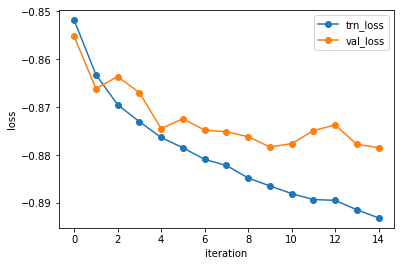

In [361]:
plt.plot(unet_model.history.history['loss'], '-o')
plt.plot(unet_model.history.history['val_loss'], '-o')
plt.legend(['trn_loss', 'val_loss'], loc='upper right')
plt.xlabel('iteration')
plt.ylabel('loss')

In [96]:
pred_box_unet = unet_model.predict(val_bbox_imgs)

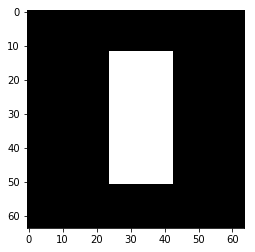

In [372]:
plt.imshow(loc_val_mask[2][:,:,0], cmap='gray')

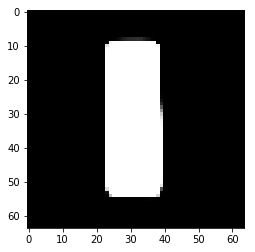

In [373]:
plt.imshow(pred_box_unet[1][:,:,0], cmap='gray')

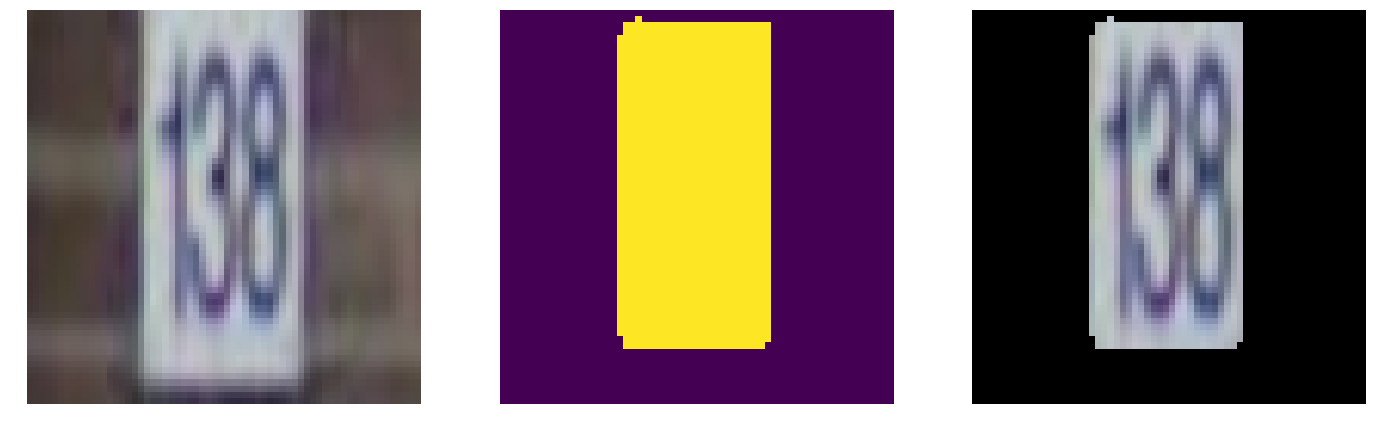

In [98]:
plot_im_mask(val_bbox_imgs[500], pred_box_unet[500] * 255.)

#### Save  and load our model

In [368]:
#unet_model.save_weights('./models/unet.h5')

In [95]:
unet_model.load_weights('./models/unet.h5')

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

The last version of my localizer seems to be performing well on the realistic dataset. The accuracy of the predicted bounding boxes are a little under 90% as measured by the Dice coefficient. 

The SVHN test dataset already includes the coordinates for the bounding boxes on the test set and this was used to assess the performance of the model on step 2. Had this information had not been provided it's safe to assume that the model would have performed significantly worse, as suggested by our test cases on step 3. In that scenario, using the number locator we just trained should bring our performance back to the levels we saw in our test.

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**
Surprisingly the model was not able to generalize for the images that I used. I suspect that the poor results on the 64 x 64 pixels image is due to the loss of information you have when downsampling the original image.

At 64  x 64 pixels it found the same "blobs" as probably the ones from where numbers were likely to be found, but the noise in the image ended up confusing the model.

I also tried to use the same weights, but change the model input to 1024 x 1024 - given that this is a fully convolutional model, I assumed that the weights could be shared between models, but the results clearly show that they cannot.

I suspect that given images that are more similar to the ones we have trained the model, it should perform better.

I have provided the examples for both cases below: 

In [502]:
new_images = []
new_filenames = []

filelist = os.listdir('./data/')

for file in filelist:

    try:
        img = cv2.imread('./data/' + file, cv2.IMREAD_COLOR)
    except:
        img = None

    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64))
        new_images.append(img)
        new_filenames.append(file)

In [503]:
new_images = np.array(new_images, dtype='float')
proc_new_images = new_images / 255 - 0.5
test_new_masks = unet_model.predict(proc_new_images, batch_size=1)

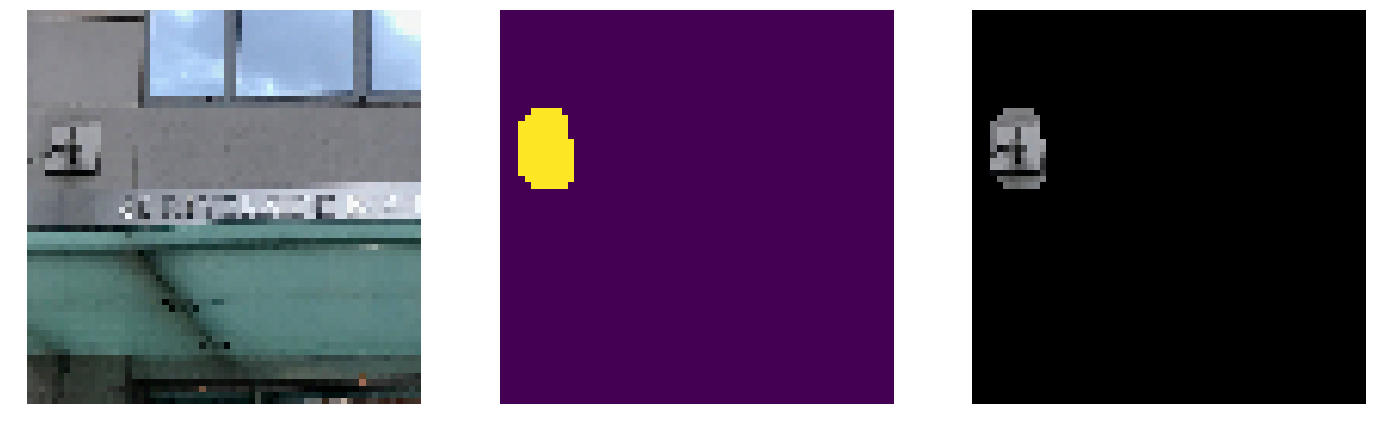

In [504]:
ref = 0 
plot_im_mask(new_images[ref], test_new_masks[ref])

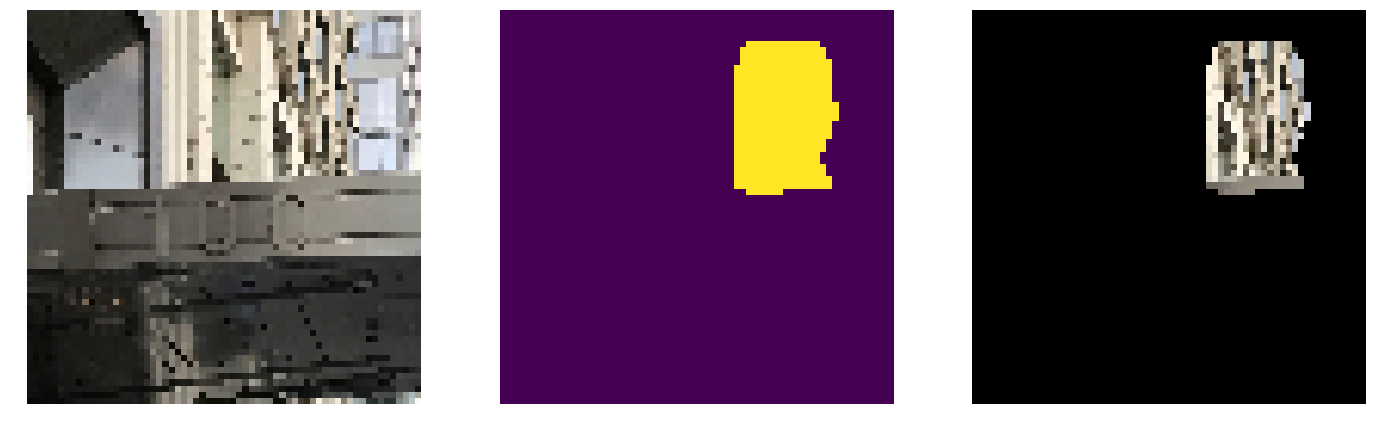

In [505]:
ref = 1 
plot_im_mask(new_images[ref], test_new_masks[ref])

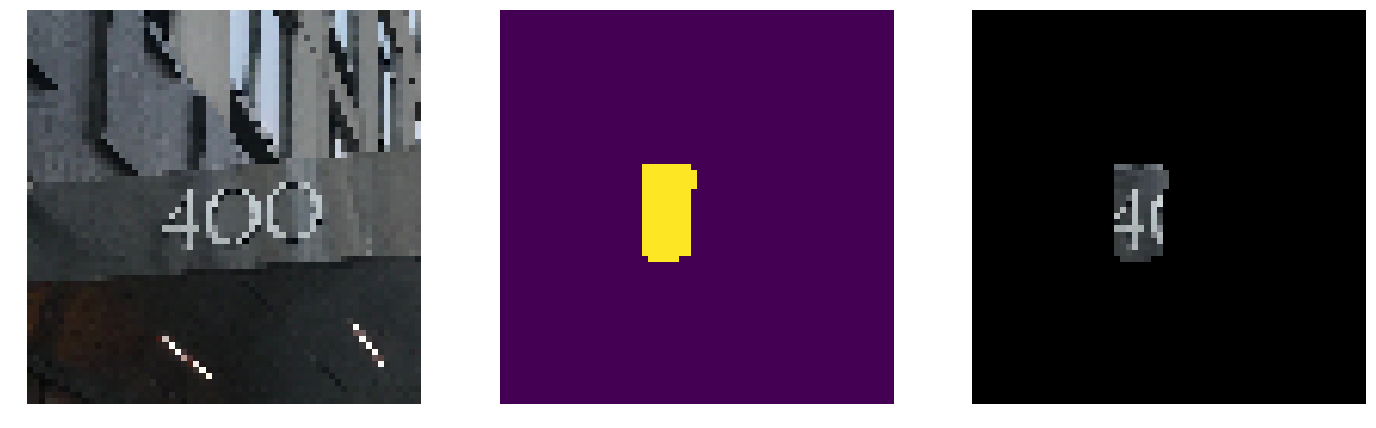

In [506]:
ref = 2 
plot_im_mask(new_images[ref], test_new_masks[ref])

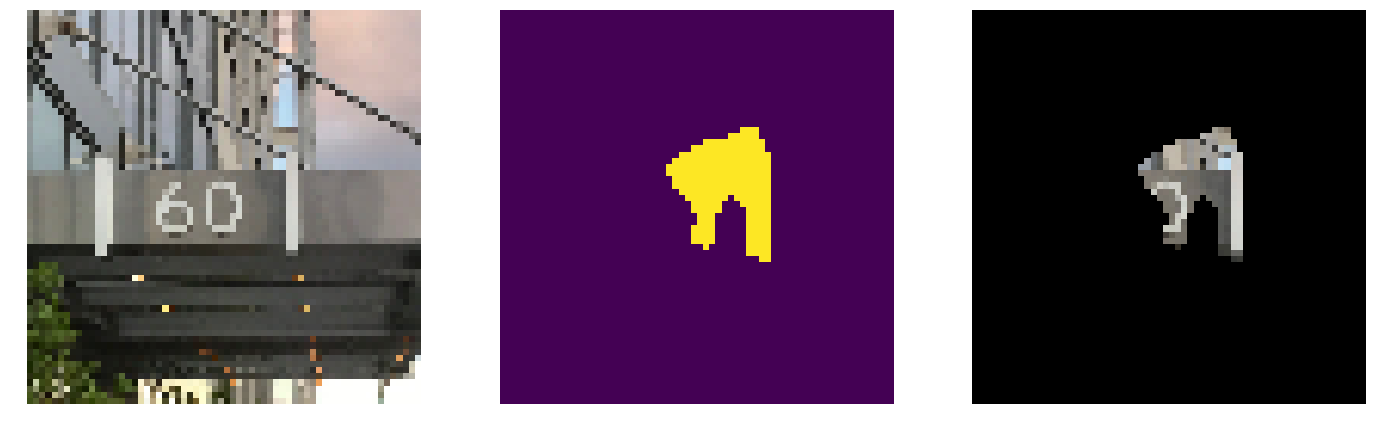

In [507]:
ref = 3 
plot_im_mask(new_images[ref], test_new_masks[ref])

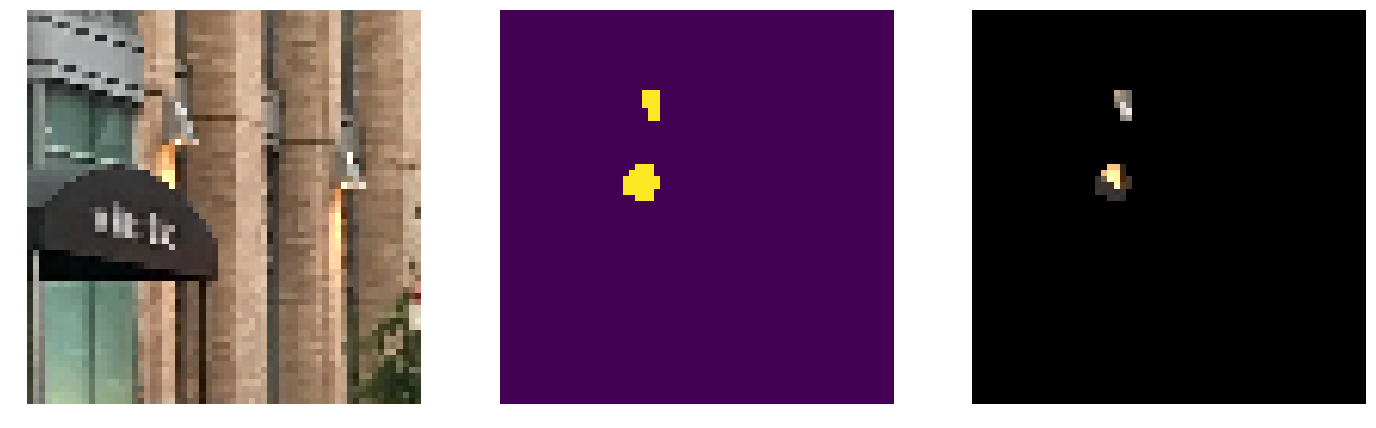

In [508]:
ref = 4 
plot_im_mask(new_images[ref], test_new_masks[ref])

In [509]:
new_images = []
new_filenames = []

filelist = os.listdir('./data/')

for file in filelist:

    try:
        img = cv2.imread('./data/' + file, cv2.IMREAD_COLOR)
    except:
        img = None

    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (1024, 1024))
        new_images.append(img)
        new_filenames.append(file)

In [510]:
unet_large = unet(input_shape=(1024, 1024, 3))
unet_large.load_weights('./models/unet.h5')

In [511]:
new_images = np.array(new_images, dtype='float')
proc_new_images = new_images / 255 - 0.5
test_new_masks = unet_large.predict(proc_new_images, batch_size=1)

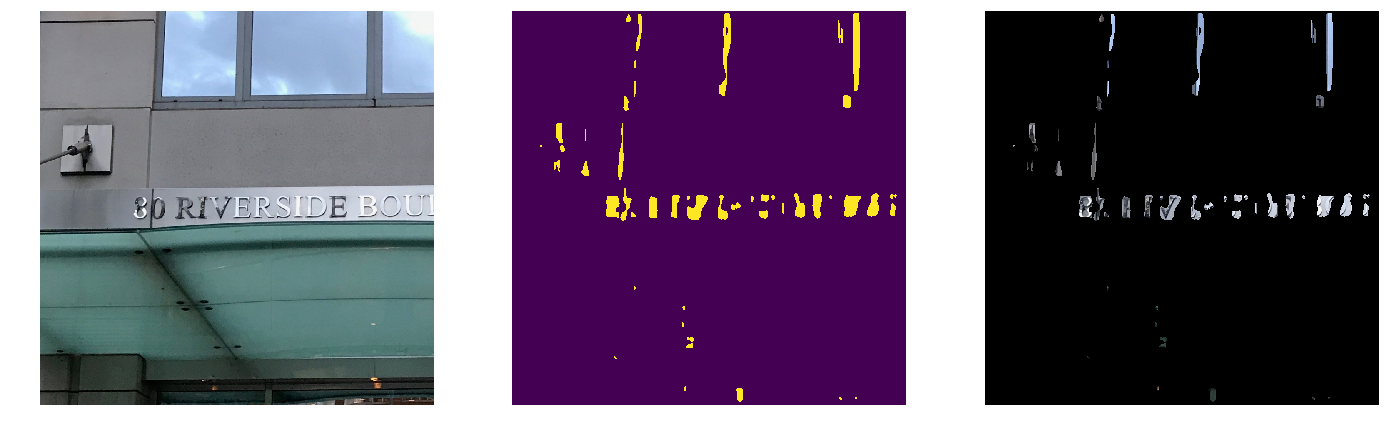

In [512]:
ref = 0 
plot_im_mask(new_images[ref], test_new_masks[ref])

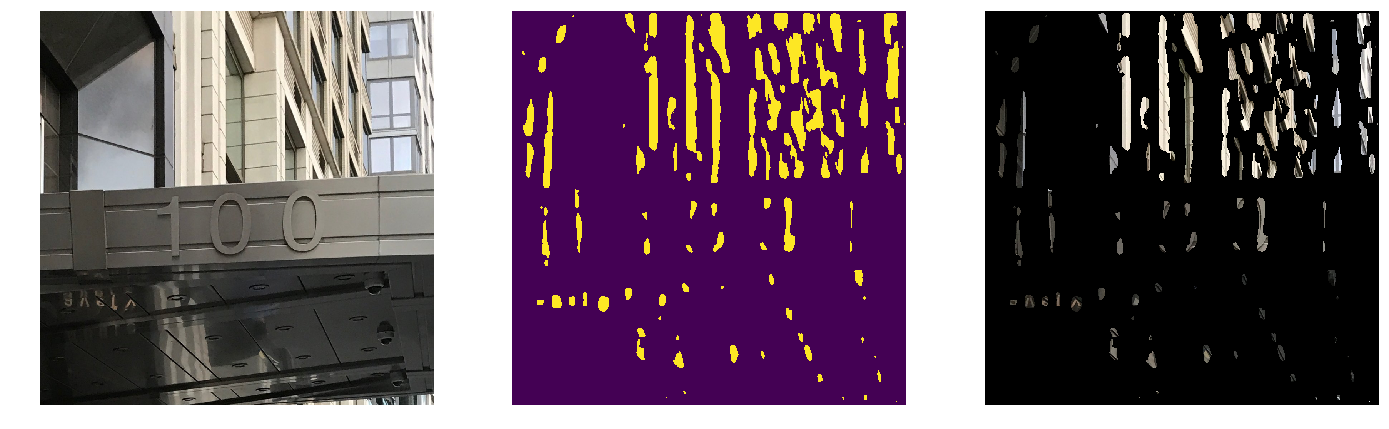

In [513]:
ref = 1 
plot_im_mask(new_images[ref], test_new_masks[ref])

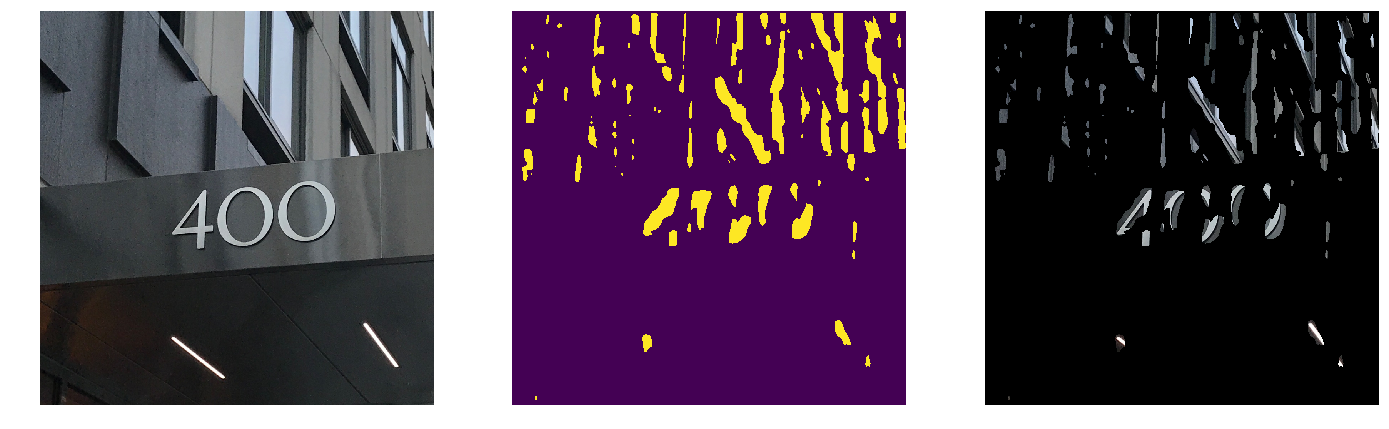

In [514]:
ref = 2 
plot_im_mask(new_images[ref], test_new_masks[ref])

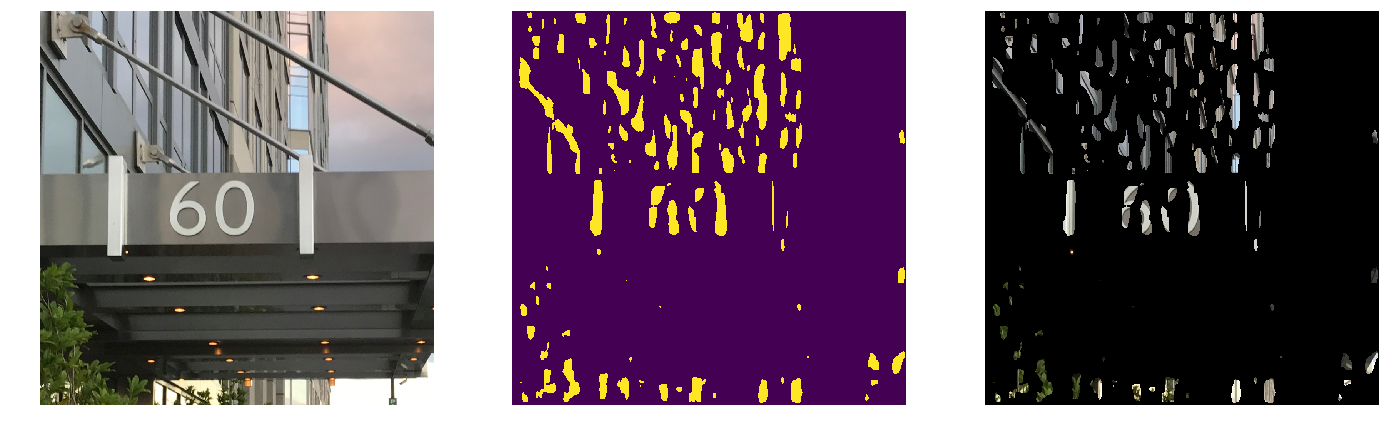

In [515]:
ref = 3 
plot_im_mask(new_images[ref], test_new_masks[ref])

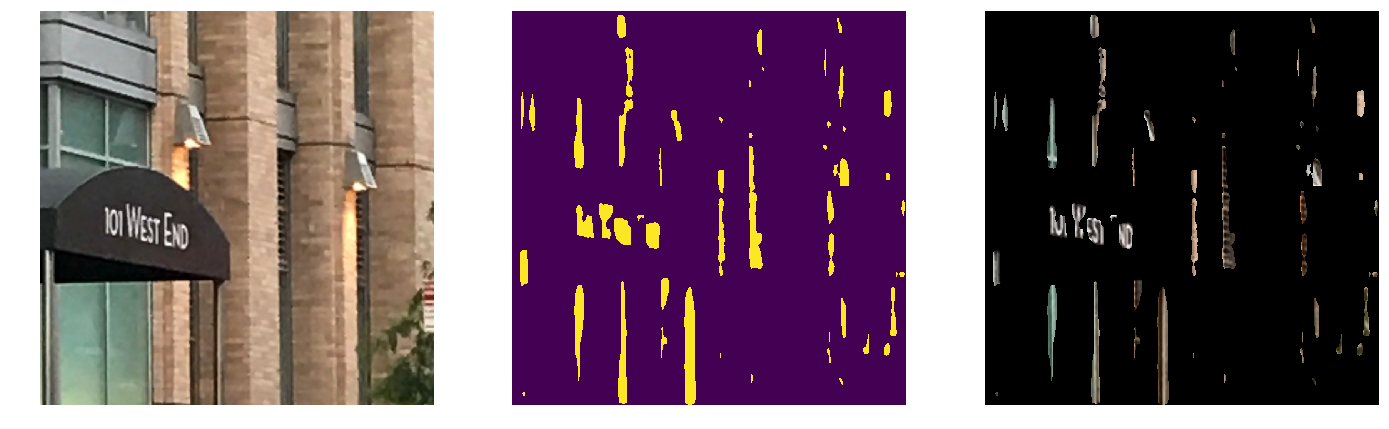

In [516]:
ref = 4 
plot_im_mask(new_images[ref], test_new_masks[ref])

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.